In [1]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration

In [2]:
import torch
import copy
import numpy as np
import os
import sys
import re
sys.path.append(os.path.dirname(os.getcwd()))
from utils.model_utils.evaluate import evaluate_model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from pathlib import Path

In [5]:
train_path = Path("../Datasets/Code/go/")
valid_path = Path("../Datasets/Code/go/")
test_path = Path("../Datasets/Code/go/")

In [6]:
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-base-multi-sum")
model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-base-multi-sum")

In [7]:
text = """def svg_to_image(string, size=None):
if isinstance(string, unicode):
    string = string.encode('utf-8')
    renderer = QtSvg.QSvgRenderer(QtCore.QByteArray(string))
if not renderer.isValid():
    raise ValueError('Invalid SVG data.')
if size is None:
    size = renderer.defaultSize()
    image = QtGui.QImage(size, QtGui.QImage.Format_ARGB32)
    painter = QtGui.QPainter(image)
    renderer.render(painter)
return image"""

In [8]:
def test(model, text):
    model = model.to(device)
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    generated_ids = model.generate(input_ids, max_length=20)
    print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

In [9]:
ref_model = copy.deepcopy(model)

In [10]:
import torch
from scipy.stats import norm


class WeightRemover:
    def __init__(self, model, device="cuda:0", p=0.8):
        self.model = model.to(device)
        self.device = device
        self.p = p
        self.results = {"layer": [], "input": [], "output": []}

    def hook(self, layer, input, output):
        self.results["layer"].append(layer)
        self.results["input"].append(input[0].to('cpu'))
        self.results["output"].append(output[0].to('cpu'))

    def register_hooks(self):
        handle_list = []
        for layer in self.model.modules():
            if isinstance(layer, torch.nn.Linear):
                handle = layer.register_forward_hook(self.hook)
                handle_list.append(handle)
        return handle_list

    def remove_hooks(self, handle_list):
        for handle in handle_list:
            handle.remove()

    def remove_weights(self, layer):
        current_weight = layer.weight.clone()
        if layer.bias is not None:
            current_bias = layer.bias.clone()
        else:
            current_bias = None

        mean = torch.mean(current_weight, dim=1, keepdim=True)
        std = torch.std(current_weight, dim=1, keepdim=True)
        z_scores = (current_weight - mean) / std

        lower_z, upper_z = norm.ppf(0.45), norm.ppf(0.55)
        mask = torch.logical_and(z_scores >= lower_z, z_scores < upper_z)

        current_weight[mask] = 0
        all_zeros = ~mask.any(dim=1)
        if current_bias is not None:
            current_bias[all_zeros] = 0
        self.set_parameters(layer, current_weight, current_bias)

    def set_parameters(self, layer, weight, bias):
        layer.weight.data = weight
        if bias is not None:
            layer.bias.data = bias

    def process(self, input_tensor, decoder_input_ids):
        self.results = {"layer": [], "input": [], "output": []}
        handle_list = self.register_hooks()
        output = self.model(input_ids=input_tensor.to(self.device), decoder_input_ids=decoder_input_ids.to(self.device))
        self.remove_hooks(handle_list)
        return output
        
    def apply_removal(self):
        total_original_weights = 0
        total_remaining_weights = 0

        for idx, layer in enumerate(self.results["layer"]):
            current_weight = layer.weight
            original_non_zero_weights = torch.sum(current_weight != 0).item()
            total_original_weights += original_non_zero_weights

            if torch.sum(current_weight != 0) > torch.numel(current_weight) * self.p:
                self.results["output"][idx] = self.results["output"][idx].to(self.device)
                self.remove_weights(layer)
                self.results["output"][idx] = self.results["output"][idx].to('cpu')

            remaining_non_zero_weights = torch.sum(layer.weight != 0).item()
            total_remaining_weights += remaining_non_zero_weights

            print(f"Layer {idx} - Original non-zero weights: {original_non_zero_weights}, Remaining non-zero weights: {remaining_non_zero_weights}, Reduction: {original_non_zero_weights - remaining_non_zero_weights}")

        print(f"Total original non-zero weights: {total_original_weights}")
        print(f"Total remaining non-zero weights: {total_remaining_weights}")
        print(f"Total reduction: {total_original_weights - total_remaining_weights}")


In [11]:
class ConcernIdentification:
    def __init__(self, ref_model, model, device='cuda:0', p=0.7):
        self.ref_model = ref_model.to(device)
        self.model = model.to(device)
        self.device = device
        self.p = p
        self.original_results = {"layer": [], "input": [], "output": []}
        self.current_results = {"layer": [], "input": [], "output": []}

    def original_hook(self, layer, input, output):
        self.original_results["layer"].append(layer)
        self.original_results["input"].append(input[0].to('cpu'))
        self.original_results["output"].append(output[0].to('cpu'))

    def current_hook(self, layer, input, output):
        self.current_results["layer"].append(layer)
        self.current_results["input"].append(input[0].to('cpu'))
        self.current_results["output"].append(output[0].to('cpu'))

    def register_hooks(self, model, hook):
        handle_list = []
        for layer in model.modules():
            if isinstance(layer, torch.nn.Linear):
                handle = layer.register_forward_hook(hook)
                handle_list.append(handle)
        return handle_list

    def remove_hooks(self, handle_list):
        for handle in handle_list:
            handle.remove()

    def prune(self, ref_model, model, original_output, output):
        current_weight = model.weight.clone()
        if model.bias is not None:
            current_bias = model.bias.clone()
        else:
            current_bias = None
        original_weight = ref_model.weight.clone()
        
        if ref_model.bias is not None:
            original_bias = ref_model.bias.clone()
        else:
            original_bias = None
        shape = current_weight.shape

        output_loss = output - original_output
        if len(output_loss.shape) > len(shape):
            output_loss = output_loss[:, 0, :]
            
        positive_loss_mask = (
            torch.all(output_loss > 0, dim=0).unsqueeze(1).expand(-1, shape[1])
        )

        original_weight_std = safe_std(original_weight, dim=1, keepdim=True)
        current_weight_std = safe_std(
            current_weight,
            epsilon=original_weight_std,
            unbiased=True,
            dim=1,
            keepdim=True,
        )

        padded_positive = torch.where(
            current_weight > 0, current_weight, torch.tensor(float("nan"))
        )
        padded_negative = torch.where(
            current_weight < 0, current_weight, torch.tensor(float("nan"))
        )
        positive_mean = torch.nanmean(padded_positive, dim=1, keepdim=True)
        negative_mean = torch.nanmean(padded_negative, dim=1, keepdim=True)

        positive_std = safe_std(
            current_weight,
            epsilon=current_weight_std,
            unbiased=True,
            dim=1,
            keepdim=True,
        )
        negative_std = safe_std(
            current_weight,
            epsilon=current_weight_std,
            unbiased=True,
            dim=1,
            keepdim=True,
        )

        positive_scores = (padded_positive - positive_mean) / positive_std
        negative_scores = (padded_negative - negative_mean) / negative_std

        positive_median = torch.nanmedian(padded_positive, dim=1, keepdim=True)
        negative_median = torch.nanmedian(padded_negative, dim=1, keepdim=True)
        lower_z, upper_z = norm.ppf(0.1), norm.ppf(0.3)

        positive_remove_mask = torch.where(
            positive_mean < positive_median.values,
            positive_scores <= lower_z,
            torch.logical_and(positive_scores >= lower_z, positive_scores < upper_z),
        )

        negative_remove_mask = torch.where(
            negative_mean < negative_median.values,
            torch.logical_and(negative_scores < -lower_z, negative_scores >= -upper_z),
            negative_scores >= -upper_z,
        )

        remove_mask = torch.where(
            ~positive_loss_mask, positive_remove_mask, negative_remove_mask
        )

        current_weight[remove_mask] = 0

        all_zeros = ~remove_mask.any(dim=1)
        if current_bias is not None:
            current_bias[all_zeros] = 0
        self.set_parameters(model, current_weight, current_bias)

    def set_parameters(self, layer, weight, bias):
        layer.weight.data = weight
        if bias is not None:
            layer.bias.data = bias

    def process(self, input_tensor, decoder_input_ids):
        self.original_results = {"layer": [], "input": [], "output": []}
        self.current_results = {"layer": [], "input": [], "output": []}

        handle_list = self.register_hooks(self.model, self.current_hook)
        self.model(input_ids=input_tensor.to(self.device), decoder_input_ids=decoder_input_ids.to(self.device))
        self.remove_hooks(handle_list)
        handle_list = self.register_hooks(self.ref_model, self.original_hook)
        self.ref_model(input_ids=input_tensor.to(self.device), decoder_input_ids=decoder_input_ids.to(self.device))
        self.remove_hooks(handle_list)

    def apply_prune(self):
        total_original_weights = 0
        total_remaining_weights = 0
        
        for idx, layer in enumerate(self.current_results["layer"]):
            current_weight = layer.weight
            original_non_zero_weights = torch.sum(current_weight != 0).item()
            total_original_weights += original_non_zero_weights
            
            if torch.sum(current_weight != 0) > torch.numel(current_weight) * self.p:
                self.original_results["output"][idx] = self.original_results["output"][idx].to(self.device)
                self.current_results["output"][idx] = self.current_results["output"][idx].to(self.device)
                self.prune(self.original_results["layer"][idx], layer, self.original_results["output"][idx],
                           self.current_results["output"][idx])
                self.original_results["output"][idx] = self.original_results["output"][idx].to('cpu')
                self.current_results["output"][idx] = self.current_results["output"][idx].to('cpu')

            remaining_non_zero_weights = torch.sum(layer.weight != 0).item()
            total_remaining_weights += remaining_non_zero_weights

            print(f"Layer {idx} - Original non-zero weights: {original_non_zero_weights}, Remaining non-zero weights: {remaining_non_zero_weights}, Reduction: {original_non_zero_weights - remaining_non_zero_weights}")
            
        
        print(f"Total original non-zero weights: {total_original_weights}")
        print(f"Total remaining non-zero weights: {total_remaining_weights}")
        print(f"Total reduction: {total_original_weights - total_remaining_weights}")                


def safe_std(tensor, epsilon=None, unbiased=False, dim=None, keepdim=True):
    if tensor.numel():
        return nanstd(tensor, dim=dim, unbiased=unbiased, keepdim=keepdim)
    else:
        return torch.tensor(epsilon, dtype=tensor.dtype)


def nanstd(tensor, unbiased=False, dim=None, keepdim=True):
    mask = torch.isnan(tensor)
    n_obs = mask.logical_not().sum(dim=dim, keepdim=keepdim)
    mean = torch.nanmean(tensor, dim=dim, keepdim=keepdim)

    centered = tensor - mean
    centered = centered.masked_fill(mask, 0)
    sum_sq = torch.sum(centered ** 2, dim=dim, keepdim=keepdim)

    unbiased_factor = torch.where(n_obs > 1, n_obs - 1, n_obs)
    var = sum_sq / unbiased_factor

    std = torch.sqrt(var)
    if not keepdim:
        std = std.squeeze(dim)
    return std

In [12]:
weight_remover = WeightRemover(model, device, 0.8)

In [13]:
batch_size = 4
sequence_length = 10

for idx in range(5):
    print(f"-------------{idx} of the ids-------------")
    random_input_ids = torch.tensor(np.random.randint(0, tokenizer.vocab_size, (batch_size, sequence_length)), dtype=torch.long)
    random_decoder_input_ids = torch.tensor(np.random.randint(0, tokenizer.vocab_size, (batch_size, sequence_length)), dtype=torch.long)
    with torch.no_grad():
        y_ = weight_remover.process(random_input_ids, random_decoder_input_ids)
    weight_remover.apply_removal()

-------------0 of the ids-------------
Layer 0 - Original non-zero weights: 589824, Remaining non-zero weights: 529869, Reduction: 59955
Layer 1 - Original non-zero weights: 589824, Remaining non-zero weights: 530119, Reduction: 59705
Layer 2 - Original non-zero weights: 589824, Remaining non-zero weights: 530293, Reduction: 59531
Layer 3 - Original non-zero weights: 589824, Remaining non-zero weights: 529914, Reduction: 59910
Layer 4 - Original non-zero weights: 2359296, Remaining non-zero weights: 2124269, Reduction: 235027
Layer 5 - Original non-zero weights: 2359296, Remaining non-zero weights: 2120295, Reduction: 239001
Layer 6 - Original non-zero weights: 589824, Remaining non-zero weights: 530228, Reduction: 59596
Layer 7 - Original non-zero weights: 589824, Remaining non-zero weights: 530697, Reduction: 59127
Layer 8 - Original non-zero weights: 589824, Remaining non-zero weights: 530473, Reduction: 59351
Layer 9 - Original non-zero weights: 589824, Remaining non-zero weights: 

In [14]:
test(ref_model, text)

2024-05-28 19:48:18.582816: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 19:48:18.620355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 19:48:19.211259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Converts a SVG string to a QImage.


In [15]:
test(model, text)

Converts a SVG string to a QImage.


In [16]:
import matplotlib.pyplot as plt

def parse_weight_data(data):
    epochs = []
    original_weights = []
    remaining_weights = []
    reductions = []

    pattern = re.compile(r'Total original non-zero weights: (\d+)\s+Total remaining non-zero weights: (\d+)\s+Total reduction: (\d+)')
    matches = pattern.findall(data)

    for i, match in enumerate(matches):
        epoch = i + 1
        original = int(match[0])
        remaining = int(match[1])
        reduction = int(match[2])

        epochs.append(epoch)
        original_weights.append(original)
        remaining_weights.append(remaining)
        reductions.append(reduction)

    return epochs, original_weights, remaining_weights, reductions

def plot_weight_changes(data):
    epochs, original_weights, remaining_weights, reductions = parse_weight_data(data)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, original_weights, label='Original Weights', marker='o')
    plt.plot(epochs, remaining_weights, label='Remaining Weights', marker='o')
    plt.plot(epochs, reductions, label='Reduction', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Number of Weights')
    plt.title('Weight Changes per Epoch')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [17]:
data = """-------------0 of the ids-------------
Layer 0 - Original non-zero weights: 589824, Remaining non-zero weights: 529869, Reduction: 59955
Layer 1 - Original non-zero weights: 589824, Remaining non-zero weights: 530119, Reduction: 59705
Layer 2 - Original non-zero weights: 589824, Remaining non-zero weights: 530293, Reduction: 59531
Layer 3 - Original non-zero weights: 589824, Remaining non-zero weights: 529914, Reduction: 59910
Layer 4 - Original non-zero weights: 2359296, Remaining non-zero weights: 2124269, Reduction: 235027
Layer 5 - Original non-zero weights: 2359296, Remaining non-zero weights: 2120295, Reduction: 239001
Layer 6 - Original non-zero weights: 589824, Remaining non-zero weights: 530228, Reduction: 59596
Layer 7 - Original non-zero weights: 589824, Remaining non-zero weights: 530697, Reduction: 59127
Layer 8 - Original non-zero weights: 589824, Remaining non-zero weights: 530473, Reduction: 59351
Layer 9 - Original non-zero weights: 589824, Remaining non-zero weights: 530063, Reduction: 59761
Layer 10 - Original non-zero weights: 2359296, Remaining non-zero weights: 2125192, Reduction: 234104
Layer 11 - Original non-zero weights: 2359296, Remaining non-zero weights: 2121137, Reduction: 238159
Layer 12 - Original non-zero weights: 589824, Remaining non-zero weights: 530467, Reduction: 59357
Layer 13 - Original non-zero weights: 589824, Remaining non-zero weights: 530742, Reduction: 59082
Layer 14 - Original non-zero weights: 589824, Remaining non-zero weights: 530223, Reduction: 59601
Layer 15 - Original non-zero weights: 589824, Remaining non-zero weights: 530434, Reduction: 59390
Layer 16 - Original non-zero weights: 2359296, Remaining non-zero weights: 2126391, Reduction: 232905
Layer 17 - Original non-zero weights: 2359296, Remaining non-zero weights: 2120713, Reduction: 238583
Layer 18 - Original non-zero weights: 589824, Remaining non-zero weights: 530597, Reduction: 59227
Layer 19 - Original non-zero weights: 589824, Remaining non-zero weights: 530650, Reduction: 59174
Layer 20 - Original non-zero weights: 589824, Remaining non-zero weights: 530154, Reduction: 59670
Layer 21 - Original non-zero weights: 589824, Remaining non-zero weights: 530587, Reduction: 59237
Layer 22 - Original non-zero weights: 2359296, Remaining non-zero weights: 2126509, Reduction: 232787
Layer 23 - Original non-zero weights: 2359296, Remaining non-zero weights: 2120482, Reduction: 238814
Layer 24 - Original non-zero weights: 589824, Remaining non-zero weights: 530721, Reduction: 59103
Layer 25 - Original non-zero weights: 589824, Remaining non-zero weights: 530760, Reduction: 59064
Layer 26 - Original non-zero weights: 589824, Remaining non-zero weights: 530047, Reduction: 59777
Layer 27 - Original non-zero weights: 589824, Remaining non-zero weights: 530616, Reduction: 59208
Layer 28 - Original non-zero weights: 2359296, Remaining non-zero weights: 2126114, Reduction: 233182
Layer 29 - Original non-zero weights: 2359296, Remaining non-zero weights: 2118426, Reduction: 240870
Layer 30 - Original non-zero weights: 589824, Remaining non-zero weights: 530453, Reduction: 59371
Layer 31 - Original non-zero weights: 589824, Remaining non-zero weights: 530258, Reduction: 59566
Layer 32 - Original non-zero weights: 589824, Remaining non-zero weights: 530155, Reduction: 59669
Layer 33 - Original non-zero weights: 589824, Remaining non-zero weights: 530383, Reduction: 59441
Layer 34 - Original non-zero weights: 2359296, Remaining non-zero weights: 2126074, Reduction: 233222
Layer 35 - Original non-zero weights: 2359296, Remaining non-zero weights: 2117350, Reduction: 241946
Layer 36 - Original non-zero weights: 589824, Remaining non-zero weights: 530342, Reduction: 59482
Layer 37 - Original non-zero weights: 589824, Remaining non-zero weights: 530458, Reduction: 59366
Layer 38 - Original non-zero weights: 589824, Remaining non-zero weights: 529505, Reduction: 60319
Layer 39 - Original non-zero weights: 589824, Remaining non-zero weights: 530633, Reduction: 59191
Layer 40 - Original non-zero weights: 2359296, Remaining non-zero weights: 2125027, Reduction: 234269
Layer 41 - Original non-zero weights: 2359296, Remaining non-zero weights: 2116441, Reduction: 242855
Layer 42 - Original non-zero weights: 589824, Remaining non-zero weights: 530846, Reduction: 58978
Layer 43 - Original non-zero weights: 589824, Remaining non-zero weights: 530688, Reduction: 59136
Layer 44 - Original non-zero weights: 589824, Remaining non-zero weights: 530594, Reduction: 59230
Layer 45 - Original non-zero weights: 589824, Remaining non-zero weights: 530125, Reduction: 59699
Layer 46 - Original non-zero weights: 2359296, Remaining non-zero weights: 2126344, Reduction: 232952
Layer 47 - Original non-zero weights: 2359296, Remaining non-zero weights: 2116745, Reduction: 242551
Layer 48 - Original non-zero weights: 589824, Remaining non-zero weights: 530587, Reduction: 59237
Layer 49 - Original non-zero weights: 589824, Remaining non-zero weights: 530423, Reduction: 59401
Layer 50 - Original non-zero weights: 589824, Remaining non-zero weights: 530025, Reduction: 59799
Layer 51 - Original non-zero weights: 589824, Remaining non-zero weights: 530274, Reduction: 59550
Layer 52 - Original non-zero weights: 2359296, Remaining non-zero weights: 2125516, Reduction: 233780
Layer 53 - Original non-zero weights: 2359296, Remaining non-zero weights: 2115121, Reduction: 244175
Layer 54 - Original non-zero weights: 589824, Remaining non-zero weights: 530530, Reduction: 59294
Layer 55 - Original non-zero weights: 589824, Remaining non-zero weights: 530688, Reduction: 59136
Layer 56 - Original non-zero weights: 589824, Remaining non-zero weights: 530586, Reduction: 59238
Layer 57 - Original non-zero weights: 589824, Remaining non-zero weights: 530041, Reduction: 59783
Layer 58 - Original non-zero weights: 2359296, Remaining non-zero weights: 2124970, Reduction: 234326
Layer 59 - Original non-zero weights: 2359296, Remaining non-zero weights: 2113039, Reduction: 246257
Layer 60 - Original non-zero weights: 589824, Remaining non-zero weights: 530483, Reduction: 59341
Layer 61 - Original non-zero weights: 589824, Remaining non-zero weights: 530579, Reduction: 59245
Layer 62 - Original non-zero weights: 589824, Remaining non-zero weights: 530652, Reduction: 59172
Layer 63 - Original non-zero weights: 589824, Remaining non-zero weights: 529017, Reduction: 60807
Layer 64 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123863, Reduction: 235433
Layer 65 - Original non-zero weights: 2359296, Remaining non-zero weights: 2109232, Reduction: 250064
Layer 66 - Original non-zero weights: 589824, Remaining non-zero weights: 530358, Reduction: 59466
Layer 67 - Original non-zero weights: 589824, Remaining non-zero weights: 530491, Reduction: 59333
Layer 68 - Original non-zero weights: 589824, Remaining non-zero weights: 529769, Reduction: 60055
Layer 69 - Original non-zero weights: 589824, Remaining non-zero weights: 529878, Reduction: 59946
Layer 70 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123056, Reduction: 236240
Layer 71 - Original non-zero weights: 2359296, Remaining non-zero weights: 2111789, Reduction: 247507
Layer 72 - Original non-zero weights: 589824, Remaining non-zero weights: 530568, Reduction: 59256
Layer 73 - Original non-zero weights: 589824, Remaining non-zero weights: 530333, Reduction: 59491
Layer 74 - Original non-zero weights: 589824, Remaining non-zero weights: 530492, Reduction: 59332
Layer 75 - Original non-zero weights: 589824, Remaining non-zero weights: 530852, Reduction: 58972
Layer 76 - Original non-zero weights: 589824, Remaining non-zero weights: 531006, Reduction: 58818
Layer 77 - Original non-zero weights: 589824, Remaining non-zero weights: 530371, Reduction: 59453
Layer 78 - Original non-zero weights: 589824, Remaining non-zero weights: 529531, Reduction: 60293
Layer 79 - Original non-zero weights: 589824, Remaining non-zero weights: 530363, Reduction: 59461
Layer 80 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123955, Reduction: 235341
Layer 81 - Original non-zero weights: 2359296, Remaining non-zero weights: 2117159, Reduction: 242137
Layer 82 - Original non-zero weights: 589824, Remaining non-zero weights: 530704, Reduction: 59120
Layer 83 - Original non-zero weights: 589824, Remaining non-zero weights: 530599, Reduction: 59225
Layer 84 - Original non-zero weights: 589824, Remaining non-zero weights: 529605, Reduction: 60219
Layer 85 - Original non-zero weights: 589824, Remaining non-zero weights: 530099, Reduction: 59725
Layer 86 - Original non-zero weights: 589824, Remaining non-zero weights: 530497, Reduction: 59327
Layer 87 - Original non-zero weights: 589824, Remaining non-zero weights: 530216, Reduction: 59608
Layer 88 - Original non-zero weights: 589824, Remaining non-zero weights: 530068, Reduction: 59756
Layer 89 - Original non-zero weights: 589824, Remaining non-zero weights: 529891, Reduction: 59933
Layer 90 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123613, Reduction: 235683
Layer 91 - Original non-zero weights: 2359296, Remaining non-zero weights: 2111704, Reduction: 247592
Layer 92 - Original non-zero weights: 589824, Remaining non-zero weights: 530544, Reduction: 59280
Layer 93 - Original non-zero weights: 589824, Remaining non-zero weights: 530345, Reduction: 59479
Layer 94 - Original non-zero weights: 589824, Remaining non-zero weights: 529556, Reduction: 60268
Layer 95 - Original non-zero weights: 589824, Remaining non-zero weights: 529537, Reduction: 60287
Layer 96 - Original non-zero weights: 589824, Remaining non-zero weights: 530955, Reduction: 58869
Layer 97 - Original non-zero weights: 589824, Remaining non-zero weights: 530262, Reduction: 59562
Layer 98 - Original non-zero weights: 589824, Remaining non-zero weights: 529769, Reduction: 60055
Layer 99 - Original non-zero weights: 589824, Remaining non-zero weights: 529724, Reduction: 60100
Layer 100 - Original non-zero weights: 2359296, Remaining non-zero weights: 2122973, Reduction: 236323
Layer 101 - Original non-zero weights: 2359296, Remaining non-zero weights: 2110699, Reduction: 248597
Layer 102 - Original non-zero weights: 589824, Remaining non-zero weights: 530761, Reduction: 59063
Layer 103 - Original non-zero weights: 589824, Remaining non-zero weights: 530213, Reduction: 59611
Layer 104 - Original non-zero weights: 589824, Remaining non-zero weights: 529472, Reduction: 60352
Layer 105 - Original non-zero weights: 589824, Remaining non-zero weights: 530120, Reduction: 59704
Layer 106 - Original non-zero weights: 589824, Remaining non-zero weights: 531149, Reduction: 58675
Layer 107 - Original non-zero weights: 589824, Remaining non-zero weights: 529920, Reduction: 59904
Layer 108 - Original non-zero weights: 589824, Remaining non-zero weights: 529934, Reduction: 59890
Layer 109 - Original non-zero weights: 589824, Remaining non-zero weights: 529914, Reduction: 59910
Layer 110 - Original non-zero weights: 2359296, Remaining non-zero weights: 2124332, Reduction: 234964
Layer 111 - Original non-zero weights: 2359296, Remaining non-zero weights: 2114787, Reduction: 244509
Layer 112 - Original non-zero weights: 589824, Remaining non-zero weights: 530809, Reduction: 59015
Layer 113 - Original non-zero weights: 589824, Remaining non-zero weights: 530221, Reduction: 59603
Layer 114 - Original non-zero weights: 589824, Remaining non-zero weights: 529928, Reduction: 59896
Layer 115 - Original non-zero weights: 589824, Remaining non-zero weights: 529996, Reduction: 59828
Layer 116 - Original non-zero weights: 589824, Remaining non-zero weights: 531364, Reduction: 58460
Layer 117 - Original non-zero weights: 589824, Remaining non-zero weights: 530113, Reduction: 59711
Layer 118 - Original non-zero weights: 589824, Remaining non-zero weights: 529307, Reduction: 60517
Layer 119 - Original non-zero weights: 589824, Remaining non-zero weights: 529377, Reduction: 60447
Layer 120 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123904, Reduction: 235392
Layer 121 - Original non-zero weights: 2359296, Remaining non-zero weights: 2117526, Reduction: 241770
Layer 122 - Original non-zero weights: 589824, Remaining non-zero weights: 530209, Reduction: 59615
Layer 123 - Original non-zero weights: 589824, Remaining non-zero weights: 530133, Reduction: 59691
Layer 124 - Original non-zero weights: 589824, Remaining non-zero weights: 530027, Reduction: 59797
Layer 125 - Original non-zero weights: 589824, Remaining non-zero weights: 530281, Reduction: 59543
Layer 126 - Original non-zero weights: 589824, Remaining non-zero weights: 530283, Reduction: 59541
Layer 127 - Original non-zero weights: 589824, Remaining non-zero weights: 530218, Reduction: 59606
Layer 128 - Original non-zero weights: 589824, Remaining non-zero weights: 530568, Reduction: 59256
Layer 129 - Original non-zero weights: 589824, Remaining non-zero weights: 530182, Reduction: 59642
Layer 130 - Original non-zero weights: 2359296, Remaining non-zero weights: 2124310, Reduction: 234986
Layer 131 - Original non-zero weights: 2359296, Remaining non-zero weights: 2117110, Reduction: 242186
Layer 132 - Original non-zero weights: 589824, Remaining non-zero weights: 530639, Reduction: 59185
Layer 133 - Original non-zero weights: 589824, Remaining non-zero weights: 530638, Reduction: 59186
Layer 134 - Original non-zero weights: 589824, Remaining non-zero weights: 529485, Reduction: 60339
Layer 135 - Original non-zero weights: 589824, Remaining non-zero weights: 528834, Reduction: 60990
Layer 136 - Original non-zero weights: 589824, Remaining non-zero weights: 530365, Reduction: 59459
Layer 137 - Original non-zero weights: 589824, Remaining non-zero weights: 530598, Reduction: 59226
Layer 138 - Original non-zero weights: 589824, Remaining non-zero weights: 530377, Reduction: 59447
Layer 139 - Original non-zero weights: 589824, Remaining non-zero weights: 530552, Reduction: 59272
Layer 140 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123976, Reduction: 235320
Layer 141 - Original non-zero weights: 2359296, Remaining non-zero weights: 2118538, Reduction: 240758
Layer 142 - Original non-zero weights: 589824, Remaining non-zero weights: 530428, Reduction: 59396
Layer 143 - Original non-zero weights: 589824, Remaining non-zero weights: 530698, Reduction: 59126
Layer 144 - Original non-zero weights: 589824, Remaining non-zero weights: 529613, Reduction: 60211
Layer 145 - Original non-zero weights: 589824, Remaining non-zero weights: 527128, Reduction: 62696
Layer 146 - Original non-zero weights: 589824, Remaining non-zero weights: 530429, Reduction: 59395
Layer 147 - Original non-zero weights: 589824, Remaining non-zero weights: 529929, Reduction: 59895
Layer 148 - Original non-zero weights: 589824, Remaining non-zero weights: 530171, Reduction: 59653
Layer 149 - Original non-zero weights: 589824, Remaining non-zero weights: 530720, Reduction: 59104
Layer 150 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123262, Reduction: 236034
Layer 151 - Original non-zero weights: 2359296, Remaining non-zero weights: 2118432, Reduction: 240864
Layer 152 - Original non-zero weights: 589824, Remaining non-zero weights: 530976, Reduction: 58848
Layer 153 - Original non-zero weights: 589824, Remaining non-zero weights: 530459, Reduction: 59365
Layer 154 - Original non-zero weights: 589824, Remaining non-zero weights: 530253, Reduction: 59571
Layer 155 - Original non-zero weights: 589824, Remaining non-zero weights: 526391, Reduction: 63433
Layer 156 - Original non-zero weights: 589824, Remaining non-zero weights: 531118, Reduction: 58706
Layer 157 - Original non-zero weights: 589824, Remaining non-zero weights: 530077, Reduction: 59747
Layer 158 - Original non-zero weights: 589824, Remaining non-zero weights: 529510, Reduction: 60314
Layer 159 - Original non-zero weights: 589824, Remaining non-zero weights: 530430, Reduction: 59394
Layer 160 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123401, Reduction: 235895
Layer 161 - Original non-zero weights: 2359296, Remaining non-zero weights: 2119910, Reduction: 239386
Layer 162 - Original non-zero weights: 589824, Remaining non-zero weights: 530779, Reduction: 59045
Layer 163 - Original non-zero weights: 589824, Remaining non-zero weights: 530813, Reduction: 59011
Layer 164 - Original non-zero weights: 589824, Remaining non-zero weights: 530519, Reduction: 59305
Layer 165 - Original non-zero weights: 589824, Remaining non-zero weights: 529424, Reduction: 60400
Layer 166 - Original non-zero weights: 589824, Remaining non-zero weights: 531334, Reduction: 58490
Layer 167 - Original non-zero weights: 589824, Remaining non-zero weights: 529955, Reduction: 59869
Layer 168 - Original non-zero weights: 589824, Remaining non-zero weights: 529290, Reduction: 60534
Layer 169 - Original non-zero weights: 589824, Remaining non-zero weights: 530848, Reduction: 58976
Layer 170 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123275, Reduction: 236021
Layer 171 - Original non-zero weights: 2359296, Remaining non-zero weights: 2121616, Reduction: 237680
Layer 172 - Original non-zero weights: 589824, Remaining non-zero weights: 530966, Reduction: 58858
Layer 173 - Original non-zero weights: 589824, Remaining non-zero weights: 530654, Reduction: 59170
Layer 174 - Original non-zero weights: 589824, Remaining non-zero weights: 529991, Reduction: 59833
Layer 175 - Original non-zero weights: 589824, Remaining non-zero weights: 530529, Reduction: 59295
Layer 176 - Original non-zero weights: 589824, Remaining non-zero weights: 530820, Reduction: 59004
Layer 177 - Original non-zero weights: 589824, Remaining non-zero weights: 529828, Reduction: 59996
Layer 178 - Original non-zero weights: 589824, Remaining non-zero weights: 529746, Reduction: 60078
Layer 179 - Original non-zero weights: 589824, Remaining non-zero weights: 530225, Reduction: 59599
Layer 180 - Original non-zero weights: 2359296, Remaining non-zero weights: 2122788, Reduction: 236508
Layer 181 - Original non-zero weights: 2359296, Remaining non-zero weights: 2120879, Reduction: 238417
Layer 182 - Original non-zero weights: 589824, Remaining non-zero weights: 530760, Reduction: 59064
Layer 183 - Original non-zero weights: 589824, Remaining non-zero weights: 530096, Reduction: 59728
Layer 184 - Original non-zero weights: 589824, Remaining non-zero weights: 530217, Reduction: 59607
Layer 185 - Original non-zero weights: 589824, Remaining non-zero weights: 530496, Reduction: 59328
Layer 186 - Original non-zero weights: 589824, Remaining non-zero weights: 531220, Reduction: 58604
Layer 187 - Original non-zero weights: 589824, Remaining non-zero weights: 529784, Reduction: 60040
Layer 188 - Original non-zero weights: 589824, Remaining non-zero weights: 529574, Reduction: 60250
Layer 189 - Original non-zero weights: 589824, Remaining non-zero weights: 530764, Reduction: 59060
Layer 190 - Original non-zero weights: 2359296, Remaining non-zero weights: 2123381, Reduction: 235915
Layer 191 - Original non-zero weights: 2359296, Remaining non-zero weights: 2120267, Reduction: 239029
Layer 192 - Original non-zero weights: 24652800, Remaining non-zero weights: 22222883, Reduction: 2429917
Total original non-zero weights: 222833664
Total remaining non-zero weights: 200374086
Total reduction: 22459578
-------------1 of the ids-------------
Layer 0 - Original non-zero weights: 529869, Remaining non-zero weights: 529125, Reduction: 744
Layer 1 - Original non-zero weights: 530119, Remaining non-zero weights: 529390, Reduction: 729
Layer 2 - Original non-zero weights: 530293, Remaining non-zero weights: 529608, Reduction: 685
Layer 3 - Original non-zero weights: 529914, Remaining non-zero weights: 529248, Reduction: 666
Layer 4 - Original non-zero weights: 2124269, Remaining non-zero weights: 2121648, Reduction: 2621
Layer 5 - Original non-zero weights: 2120295, Remaining non-zero weights: 2118359, Reduction: 1936
Layer 6 - Original non-zero weights: 530228, Remaining non-zero weights: 529494, Reduction: 734
Layer 7 - Original non-zero weights: 530697, Remaining non-zero weights: 530031, Reduction: 666
Layer 8 - Original non-zero weights: 530473, Remaining non-zero weights: 529748, Reduction: 725
Layer 9 - Original non-zero weights: 530063, Remaining non-zero weights: 529387, Reduction: 676
Layer 10 - Original non-zero weights: 2125192, Remaining non-zero weights: 2122457, Reduction: 2735
Layer 11 - Original non-zero weights: 2121137, Remaining non-zero weights: 2118530, Reduction: 2607
Layer 12 - Original non-zero weights: 530467, Remaining non-zero weights: 529738, Reduction: 729
Layer 13 - Original non-zero weights: 530742, Remaining non-zero weights: 530078, Reduction: 664
Layer 14 - Original non-zero weights: 530223, Remaining non-zero weights: 529462, Reduction: 761
Layer 15 - Original non-zero weights: 530434, Remaining non-zero weights: 529724, Reduction: 710
Layer 16 - Original non-zero weights: 2126391, Remaining non-zero weights: 2123502, Reduction: 2889
Layer 17 - Original non-zero weights: 2120713, Remaining non-zero weights: 2117657, Reduction: 3056
Layer 18 - Original non-zero weights: 530597, Remaining non-zero weights: 529884, Reduction: 713
Layer 19 - Original non-zero weights: 530650, Remaining non-zero weights: 530013, Reduction: 637
Layer 20 - Original non-zero weights: 530154, Remaining non-zero weights: 529421, Reduction: 733
Layer 21 - Original non-zero weights: 530587, Remaining non-zero weights: 529940, Reduction: 647
Layer 22 - Original non-zero weights: 2126509, Remaining non-zero weights: 2123761, Reduction: 2748
Layer 23 - Original non-zero weights: 2120482, Remaining non-zero weights: 2117322, Reduction: 3160
Layer 24 - Original non-zero weights: 530721, Remaining non-zero weights: 530032, Reduction: 689
Layer 25 - Original non-zero weights: 530760, Remaining non-zero weights: 530085, Reduction: 675
Layer 26 - Original non-zero weights: 530047, Remaining non-zero weights: 529340, Reduction: 707
Layer 27 - Original non-zero weights: 530616, Remaining non-zero weights: 529873, Reduction: 743
Layer 28 - Original non-zero weights: 2126114, Remaining non-zero weights: 2123354, Reduction: 2760
Layer 29 - Original non-zero weights: 2118426, Remaining non-zero weights: 2115643, Reduction: 2783
Layer 30 - Original non-zero weights: 530453, Remaining non-zero weights: 529813, Reduction: 640
Layer 31 - Original non-zero weights: 530258, Remaining non-zero weights: 529587, Reduction: 671
Layer 32 - Original non-zero weights: 530155, Remaining non-zero weights: 529455, Reduction: 700
Layer 33 - Original non-zero weights: 530383, Remaining non-zero weights: 529644, Reduction: 739
Layer 34 - Original non-zero weights: 2126074, Remaining non-zero weights: 2123426, Reduction: 2648
Layer 35 - Original non-zero weights: 2117350, Remaining non-zero weights: 2114678, Reduction: 2672
Layer 36 - Original non-zero weights: 530342, Remaining non-zero weights: 529641, Reduction: 701
Layer 37 - Original non-zero weights: 530458, Remaining non-zero weights: 529746, Reduction: 712
Layer 38 - Original non-zero weights: 529505, Remaining non-zero weights: 528818, Reduction: 687
Layer 39 - Original non-zero weights: 530633, Remaining non-zero weights: 529936, Reduction: 697
Layer 40 - Original non-zero weights: 2125027, Remaining non-zero weights: 2122266, Reduction: 2761
Layer 41 - Original non-zero weights: 2116441, Remaining non-zero weights: 2113892, Reduction: 2549
Layer 42 - Original non-zero weights: 530846, Remaining non-zero weights: 530172, Reduction: 674
Layer 43 - Original non-zero weights: 530688, Remaining non-zero weights: 529994, Reduction: 694
Layer 44 - Original non-zero weights: 530594, Remaining non-zero weights: 529861, Reduction: 733
Layer 45 - Original non-zero weights: 530125, Remaining non-zero weights: 529450, Reduction: 675
Layer 46 - Original non-zero weights: 2126344, Remaining non-zero weights: 2123678, Reduction: 2666
Layer 47 - Original non-zero weights: 2116745, Remaining non-zero weights: 2114110, Reduction: 2635
Layer 48 - Original non-zero weights: 530587, Remaining non-zero weights: 529853, Reduction: 734
Layer 49 - Original non-zero weights: 530423, Remaining non-zero weights: 529683, Reduction: 740
Layer 50 - Original non-zero weights: 530025, Remaining non-zero weights: 529313, Reduction: 712
Layer 51 - Original non-zero weights: 530274, Remaining non-zero weights: 529511, Reduction: 763
Layer 52 - Original non-zero weights: 2125516, Remaining non-zero weights: 2122710, Reduction: 2806
Layer 53 - Original non-zero weights: 2115121, Remaining non-zero weights: 2112247, Reduction: 2874
Layer 54 - Original non-zero weights: 530530, Remaining non-zero weights: 529843, Reduction: 687
Layer 55 - Original non-zero weights: 530688, Remaining non-zero weights: 529991, Reduction: 697
Layer 56 - Original non-zero weights: 530586, Remaining non-zero weights: 529844, Reduction: 742
Layer 57 - Original non-zero weights: 530041, Remaining non-zero weights: 529384, Reduction: 657
Layer 58 - Original non-zero weights: 2124970, Remaining non-zero weights: 2122299, Reduction: 2671
Layer 59 - Original non-zero weights: 2113039, Remaining non-zero weights: 2110391, Reduction: 2648
Layer 60 - Original non-zero weights: 530483, Remaining non-zero weights: 529805, Reduction: 678
Layer 61 - Original non-zero weights: 530579, Remaining non-zero weights: 529907, Reduction: 672
Layer 62 - Original non-zero weights: 530652, Remaining non-zero weights: 529923, Reduction: 729
Layer 63 - Original non-zero weights: 529017, Remaining non-zero weights: 528332, Reduction: 685
Layer 64 - Original non-zero weights: 2123863, Remaining non-zero weights: 2121097, Reduction: 2766
Layer 65 - Original non-zero weights: 2109232, Remaining non-zero weights: 2106524, Reduction: 2708
Layer 66 - Original non-zero weights: 530358, Remaining non-zero weights: 529657, Reduction: 701
Layer 67 - Original non-zero weights: 530491, Remaining non-zero weights: 529766, Reduction: 725
Layer 68 - Original non-zero weights: 529769, Remaining non-zero weights: 529015, Reduction: 754
Layer 69 - Original non-zero weights: 529878, Remaining non-zero weights: 529165, Reduction: 713
Layer 70 - Original non-zero weights: 2123056, Remaining non-zero weights: 2120328, Reduction: 2728
Layer 71 - Original non-zero weights: 2111789, Remaining non-zero weights: 2109190, Reduction: 2599
Layer 72 - Original non-zero weights: 530568, Remaining non-zero weights: 529855, Reduction: 713
Layer 73 - Original non-zero weights: 530333, Remaining non-zero weights: 529649, Reduction: 684
Layer 74 - Original non-zero weights: 530492, Remaining non-zero weights: 529806, Reduction: 686
Layer 75 - Original non-zero weights: 530852, Remaining non-zero weights: 530171, Reduction: 681
Layer 76 - Original non-zero weights: 531006, Remaining non-zero weights: 530303, Reduction: 703
Layer 77 - Original non-zero weights: 530371, Remaining non-zero weights: 529621, Reduction: 750
Layer 78 - Original non-zero weights: 529531, Remaining non-zero weights: 528829, Reduction: 702
Layer 79 - Original non-zero weights: 530363, Remaining non-zero weights: 529645, Reduction: 718
Layer 80 - Original non-zero weights: 2123955, Remaining non-zero weights: 2121244, Reduction: 2711
Layer 81 - Original non-zero weights: 2117159, Remaining non-zero weights: 2115165, Reduction: 1994
Layer 82 - Original non-zero weights: 530704, Remaining non-zero weights: 530045, Reduction: 659
Layer 83 - Original non-zero weights: 530599, Remaining non-zero weights: 529915, Reduction: 684
Layer 84 - Original non-zero weights: 529605, Remaining non-zero weights: 528943, Reduction: 662
Layer 85 - Original non-zero weights: 530099, Remaining non-zero weights: 529399, Reduction: 700
Layer 86 - Original non-zero weights: 530497, Remaining non-zero weights: 529804, Reduction: 693
Layer 87 - Original non-zero weights: 530216, Remaining non-zero weights: 529498, Reduction: 718
Layer 88 - Original non-zero weights: 530068, Remaining non-zero weights: 529316, Reduction: 752
Layer 89 - Original non-zero weights: 529891, Remaining non-zero weights: 529233, Reduction: 658
Layer 90 - Original non-zero weights: 2123613, Remaining non-zero weights: 2120849, Reduction: 2764
Layer 91 - Original non-zero weights: 2111704, Remaining non-zero weights: 2108464, Reduction: 3240
Layer 92 - Original non-zero weights: 530544, Remaining non-zero weights: 529887, Reduction: 657
Layer 93 - Original non-zero weights: 530345, Remaining non-zero weights: 529627, Reduction: 718
Layer 94 - Original non-zero weights: 529556, Remaining non-zero weights: 528839, Reduction: 717
Layer 95 - Original non-zero weights: 529537, Remaining non-zero weights: 528834, Reduction: 703
Layer 96 - Original non-zero weights: 530955, Remaining non-zero weights: 530203, Reduction: 752
Layer 97 - Original non-zero weights: 530262, Remaining non-zero weights: 529528, Reduction: 734
Layer 98 - Original non-zero weights: 529769, Remaining non-zero weights: 529057, Reduction: 712
Layer 99 - Original non-zero weights: 529724, Remaining non-zero weights: 529022, Reduction: 702
Layer 100 - Original non-zero weights: 2122973, Remaining non-zero weights: 2120173, Reduction: 2800
Layer 101 - Original non-zero weights: 2110699, Remaining non-zero weights: 2107189, Reduction: 3510
Layer 102 - Original non-zero weights: 530761, Remaining non-zero weights: 530075, Reduction: 686
Layer 103 - Original non-zero weights: 530213, Remaining non-zero weights: 529530, Reduction: 683
Layer 104 - Original non-zero weights: 529472, Remaining non-zero weights: 528801, Reduction: 671
Layer 105 - Original non-zero weights: 530120, Remaining non-zero weights: 529433, Reduction: 687
Layer 106 - Original non-zero weights: 531149, Remaining non-zero weights: 530433, Reduction: 716
Layer 107 - Original non-zero weights: 529920, Remaining non-zero weights: 529187, Reduction: 733
Layer 108 - Original non-zero weights: 529934, Remaining non-zero weights: 529203, Reduction: 731
Layer 109 - Original non-zero weights: 529914, Remaining non-zero weights: 529208, Reduction: 706
Layer 110 - Original non-zero weights: 2124332, Remaining non-zero weights: 2121587, Reduction: 2745
Layer 111 - Original non-zero weights: 2114787, Remaining non-zero weights: 2112023, Reduction: 2764
Layer 112 - Original non-zero weights: 530809, Remaining non-zero weights: 530101, Reduction: 708
Layer 113 - Original non-zero weights: 530221, Remaining non-zero weights: 529556, Reduction: 665
Layer 114 - Original non-zero weights: 529928, Remaining non-zero weights: 529205, Reduction: 723
Layer 115 - Original non-zero weights: 529996, Remaining non-zero weights: 529271, Reduction: 725
Layer 116 - Original non-zero weights: 531364, Remaining non-zero weights: 530679, Reduction: 685
Layer 117 - Original non-zero weights: 530113, Remaining non-zero weights: 529365, Reduction: 748
Layer 118 - Original non-zero weights: 529307, Remaining non-zero weights: 528591, Reduction: 716
Layer 119 - Original non-zero weights: 529377, Remaining non-zero weights: 528697, Reduction: 680
Layer 120 - Original non-zero weights: 2123904, Remaining non-zero weights: 2121154, Reduction: 2750
Layer 121 - Original non-zero weights: 2117526, Remaining non-zero weights: 2115090, Reduction: 2436
Layer 122 - Original non-zero weights: 530209, Remaining non-zero weights: 529531, Reduction: 678
Layer 123 - Original non-zero weights: 530133, Remaining non-zero weights: 529468, Reduction: 665
Layer 124 - Original non-zero weights: 530027, Remaining non-zero weights: 529325, Reduction: 702
Layer 125 - Original non-zero weights: 530281, Remaining non-zero weights: 529552, Reduction: 729
Layer 126 - Original non-zero weights: 530283, Remaining non-zero weights: 529523, Reduction: 760
Layer 127 - Original non-zero weights: 530218, Remaining non-zero weights: 529512, Reduction: 706
Layer 128 - Original non-zero weights: 530568, Remaining non-zero weights: 529856, Reduction: 712
Layer 129 - Original non-zero weights: 530182, Remaining non-zero weights: 529449, Reduction: 733
Layer 130 - Original non-zero weights: 2124310, Remaining non-zero weights: 2121597, Reduction: 2713
Layer 131 - Original non-zero weights: 2117110, Remaining non-zero weights: 2114738, Reduction: 2372
Layer 132 - Original non-zero weights: 530639, Remaining non-zero weights: 529954, Reduction: 685
Layer 133 - Original non-zero weights: 530638, Remaining non-zero weights: 529931, Reduction: 707
Layer 134 - Original non-zero weights: 529485, Remaining non-zero weights: 528775, Reduction: 710
Layer 135 - Original non-zero weights: 528834, Remaining non-zero weights: 528114, Reduction: 720
Layer 136 - Original non-zero weights: 530365, Remaining non-zero weights: 529649, Reduction: 716
Layer 137 - Original non-zero weights: 530598, Remaining non-zero weights: 529876, Reduction: 722
Layer 138 - Original non-zero weights: 530377, Remaining non-zero weights: 529677, Reduction: 700
Layer 139 - Original non-zero weights: 530552, Remaining non-zero weights: 529849, Reduction: 703
Layer 140 - Original non-zero weights: 2123976, Remaining non-zero weights: 2121239, Reduction: 2737
Layer 141 - Original non-zero weights: 2118538, Remaining non-zero weights: 2116396, Reduction: 2142
Layer 142 - Original non-zero weights: 530428, Remaining non-zero weights: 529707, Reduction: 721
Layer 143 - Original non-zero weights: 530698, Remaining non-zero weights: 530025, Reduction: 673
Layer 144 - Original non-zero weights: 529613, Remaining non-zero weights: 528944, Reduction: 669
Layer 145 - Original non-zero weights: 527128, Remaining non-zero weights: 526435, Reduction: 693
Layer 146 - Original non-zero weights: 530429, Remaining non-zero weights: 529680, Reduction: 749
Layer 147 - Original non-zero weights: 529929, Remaining non-zero weights: 529238, Reduction: 691
Layer 148 - Original non-zero weights: 530171, Remaining non-zero weights: 529453, Reduction: 718
Layer 149 - Original non-zero weights: 530720, Remaining non-zero weights: 530022, Reduction: 698
Layer 150 - Original non-zero weights: 2123262, Remaining non-zero weights: 2120545, Reduction: 2717
Layer 151 - Original non-zero weights: 2118432, Remaining non-zero weights: 2116449, Reduction: 1983
Layer 152 - Original non-zero weights: 530976, Remaining non-zero weights: 530379, Reduction: 597
Layer 153 - Original non-zero weights: 530459, Remaining non-zero weights: 529745, Reduction: 714
Layer 154 - Original non-zero weights: 530253, Remaining non-zero weights: 529519, Reduction: 734
Layer 155 - Original non-zero weights: 526391, Remaining non-zero weights: 525602, Reduction: 789
Layer 156 - Original non-zero weights: 531118, Remaining non-zero weights: 530449, Reduction: 669
Layer 157 - Original non-zero weights: 530077, Remaining non-zero weights: 529322, Reduction: 755
Layer 158 - Original non-zero weights: 529510, Remaining non-zero weights: 528777, Reduction: 733
Layer 159 - Original non-zero weights: 530430, Remaining non-zero weights: 529727, Reduction: 703
Layer 160 - Original non-zero weights: 2123401, Remaining non-zero weights: 2120542, Reduction: 2859
Layer 161 - Original non-zero weights: 2119910, Remaining non-zero weights: 2118341, Reduction: 1569
Layer 162 - Original non-zero weights: 530779, Remaining non-zero weights: 530100, Reduction: 679
Layer 163 - Original non-zero weights: 530813, Remaining non-zero weights: 530079, Reduction: 734
Layer 164 - Original non-zero weights: 530519, Remaining non-zero weights: 529769, Reduction: 750
Layer 165 - Original non-zero weights: 529424, Remaining non-zero weights: 528661, Reduction: 763
Layer 166 - Original non-zero weights: 531334, Remaining non-zero weights: 530610, Reduction: 724
Layer 167 - Original non-zero weights: 529955, Remaining non-zero weights: 529194, Reduction: 761
Layer 168 - Original non-zero weights: 529290, Remaining non-zero weights: 528587, Reduction: 703
Layer 169 - Original non-zero weights: 530848, Remaining non-zero weights: 530165, Reduction: 683
Layer 170 - Original non-zero weights: 2123275, Remaining non-zero weights: 2120504, Reduction: 2771
Layer 171 - Original non-zero weights: 2121616, Remaining non-zero weights: 2120120, Reduction: 1496
Layer 172 - Original non-zero weights: 530966, Remaining non-zero weights: 530317, Reduction: 649
Layer 173 - Original non-zero weights: 530654, Remaining non-zero weights: 529919, Reduction: 735
Layer 174 - Original non-zero weights: 529991, Remaining non-zero weights: 529346, Reduction: 645
Layer 175 - Original non-zero weights: 530529, Remaining non-zero weights: 529808, Reduction: 721
Layer 176 - Original non-zero weights: 530820, Remaining non-zero weights: 530102, Reduction: 718
Layer 177 - Original non-zero weights: 529828, Remaining non-zero weights: 529031, Reduction: 797
Layer 178 - Original non-zero weights: 529746, Remaining non-zero weights: 529022, Reduction: 724
Layer 179 - Original non-zero weights: 530225, Remaining non-zero weights: 529579, Reduction: 646
Layer 180 - Original non-zero weights: 2122788, Remaining non-zero weights: 2119916, Reduction: 2872
Layer 181 - Original non-zero weights: 2120879, Remaining non-zero weights: 2119305, Reduction: 1574
Layer 182 - Original non-zero weights: 530760, Remaining non-zero weights: 530097, Reduction: 663
Layer 183 - Original non-zero weights: 530096, Remaining non-zero weights: 529395, Reduction: 701
Layer 184 - Original non-zero weights: 530217, Remaining non-zero weights: 529526, Reduction: 691
Layer 185 - Original non-zero weights: 530496, Remaining non-zero weights: 529820, Reduction: 676
Layer 186 - Original non-zero weights: 531220, Remaining non-zero weights: 530519, Reduction: 701
Layer 187 - Original non-zero weights: 529784, Remaining non-zero weights: 529091, Reduction: 693
Layer 188 - Original non-zero weights: 529574, Remaining non-zero weights: 528836, Reduction: 738
Layer 189 - Original non-zero weights: 530764, Remaining non-zero weights: 530097, Reduction: 667
Layer 190 - Original non-zero weights: 2123381, Remaining non-zero weights: 2120468, Reduction: 2913
Layer 191 - Original non-zero weights: 2120267, Remaining non-zero weights: 2118721, Reduction: 1546
Layer 192 - Original non-zero weights: 22222883, Remaining non-zero weights: 22194663, Reduction: 28220
Total original non-zero weights: 200374086
Total remaining non-zero weights: 200119380
Total reduction: 254706
-------------2 of the ids-------------
Layer 0 - Original non-zero weights: 529125, Remaining non-zero weights: 529125, Reduction: 0
Layer 1 - Original non-zero weights: 529390, Remaining non-zero weights: 529390, Reduction: 0
Layer 2 - Original non-zero weights: 529608, Remaining non-zero weights: 529608, Reduction: 0
Layer 3 - Original non-zero weights: 529248, Remaining non-zero weights: 529248, Reduction: 0
Layer 4 - Original non-zero weights: 2121648, Remaining non-zero weights: 2121648, Reduction: 0
Layer 5 - Original non-zero weights: 2118359, Remaining non-zero weights: 2118346, Reduction: 13
Layer 6 - Original non-zero weights: 529494, Remaining non-zero weights: 529494, Reduction: 0
Layer 7 - Original non-zero weights: 530031, Remaining non-zero weights: 530031, Reduction: 0
Layer 8 - Original non-zero weights: 529748, Remaining non-zero weights: 529748, Reduction: 0
Layer 9 - Original non-zero weights: 529387, Remaining non-zero weights: 529387, Reduction: 0
Layer 10 - Original non-zero weights: 2122457, Remaining non-zero weights: 2122457, Reduction: 0
Layer 11 - Original non-zero weights: 2118530, Remaining non-zero weights: 2118478, Reduction: 52
Layer 12 - Original non-zero weights: 529738, Remaining non-zero weights: 529738, Reduction: 0
Layer 13 - Original non-zero weights: 530078, Remaining non-zero weights: 530078, Reduction: 0
Layer 14 - Original non-zero weights: 529462, Remaining non-zero weights: 529462, Reduction: 0
Layer 15 - Original non-zero weights: 529724, Remaining non-zero weights: 529724, Reduction: 0
Layer 16 - Original non-zero weights: 2123502, Remaining non-zero weights: 2123502, Reduction: 0
Layer 17 - Original non-zero weights: 2117657, Remaining non-zero weights: 2117607, Reduction: 50
Layer 18 - Original non-zero weights: 529884, Remaining non-zero weights: 529884, Reduction: 0
Layer 19 - Original non-zero weights: 530013, Remaining non-zero weights: 530013, Reduction: 0
Layer 20 - Original non-zero weights: 529421, Remaining non-zero weights: 529421, Reduction: 0
Layer 21 - Original non-zero weights: 529940, Remaining non-zero weights: 529940, Reduction: 0
Layer 22 - Original non-zero weights: 2123761, Remaining non-zero weights: 2123761, Reduction: 0
Layer 23 - Original non-zero weights: 2117322, Remaining non-zero weights: 2117275, Reduction: 47
Layer 24 - Original non-zero weights: 530032, Remaining non-zero weights: 530032, Reduction: 0
Layer 25 - Original non-zero weights: 530085, Remaining non-zero weights: 530085, Reduction: 0
Layer 26 - Original non-zero weights: 529340, Remaining non-zero weights: 529340, Reduction: 0
Layer 27 - Original non-zero weights: 529873, Remaining non-zero weights: 529873, Reduction: 0
Layer 28 - Original non-zero weights: 2123354, Remaining non-zero weights: 2123354, Reduction: 0
Layer 29 - Original non-zero weights: 2115643, Remaining non-zero weights: 2115614, Reduction: 29
Layer 30 - Original non-zero weights: 529813, Remaining non-zero weights: 529813, Reduction: 0
Layer 31 - Original non-zero weights: 529587, Remaining non-zero weights: 529587, Reduction: 0
Layer 32 - Original non-zero weights: 529455, Remaining non-zero weights: 529455, Reduction: 0
Layer 33 - Original non-zero weights: 529644, Remaining non-zero weights: 529644, Reduction: 0
Layer 34 - Original non-zero weights: 2123426, Remaining non-zero weights: 2123426, Reduction: 0
Layer 35 - Original non-zero weights: 2114678, Remaining non-zero weights: 2114666, Reduction: 12
Layer 36 - Original non-zero weights: 529641, Remaining non-zero weights: 529641, Reduction: 0
Layer 37 - Original non-zero weights: 529746, Remaining non-zero weights: 529746, Reduction: 0
Layer 38 - Original non-zero weights: 528818, Remaining non-zero weights: 528818, Reduction: 0
Layer 39 - Original non-zero weights: 529936, Remaining non-zero weights: 529936, Reduction: 0
Layer 40 - Original non-zero weights: 2122266, Remaining non-zero weights: 2122266, Reduction: 0
Layer 41 - Original non-zero weights: 2113892, Remaining non-zero weights: 2113877, Reduction: 15
Layer 42 - Original non-zero weights: 530172, Remaining non-zero weights: 530172, Reduction: 0
Layer 43 - Original non-zero weights: 529994, Remaining non-zero weights: 529994, Reduction: 0
Layer 44 - Original non-zero weights: 529861, Remaining non-zero weights: 529861, Reduction: 0
Layer 45 - Original non-zero weights: 529450, Remaining non-zero weights: 529450, Reduction: 0
Layer 46 - Original non-zero weights: 2123678, Remaining non-zero weights: 2123678, Reduction: 0
Layer 47 - Original non-zero weights: 2114110, Remaining non-zero weights: 2114101, Reduction: 9
Layer 48 - Original non-zero weights: 529853, Remaining non-zero weights: 529853, Reduction: 0
Layer 49 - Original non-zero weights: 529683, Remaining non-zero weights: 529683, Reduction: 0
Layer 50 - Original non-zero weights: 529313, Remaining non-zero weights: 529313, Reduction: 0
Layer 51 - Original non-zero weights: 529511, Remaining non-zero weights: 529511, Reduction: 0
Layer 52 - Original non-zero weights: 2122710, Remaining non-zero weights: 2122710, Reduction: 0
Layer 53 - Original non-zero weights: 2112247, Remaining non-zero weights: 2112229, Reduction: 18
Layer 54 - Original non-zero weights: 529843, Remaining non-zero weights: 529843, Reduction: 0
Layer 55 - Original non-zero weights: 529991, Remaining non-zero weights: 529990, Reduction: 1
Layer 56 - Original non-zero weights: 529844, Remaining non-zero weights: 529844, Reduction: 0
Layer 57 - Original non-zero weights: 529384, Remaining non-zero weights: 529384, Reduction: 0
Layer 58 - Original non-zero weights: 2122299, Remaining non-zero weights: 2122299, Reduction: 0
Layer 59 - Original non-zero weights: 2110391, Remaining non-zero weights: 2110364, Reduction: 27
Layer 60 - Original non-zero weights: 529805, Remaining non-zero weights: 529805, Reduction: 0
Layer 61 - Original non-zero weights: 529907, Remaining non-zero weights: 529907, Reduction: 0
Layer 62 - Original non-zero weights: 529923, Remaining non-zero weights: 529923, Reduction: 0
Layer 63 - Original non-zero weights: 528332, Remaining non-zero weights: 528332, Reduction: 0
Layer 64 - Original non-zero weights: 2121097, Remaining non-zero weights: 2121097, Reduction: 0
Layer 65 - Original non-zero weights: 2106524, Remaining non-zero weights: 2106456, Reduction: 68
Layer 66 - Original non-zero weights: 529657, Remaining non-zero weights: 529657, Reduction: 0
Layer 67 - Original non-zero weights: 529766, Remaining non-zero weights: 529766, Reduction: 0
Layer 68 - Original non-zero weights: 529015, Remaining non-zero weights: 529015, Reduction: 0
Layer 69 - Original non-zero weights: 529165, Remaining non-zero weights: 529165, Reduction: 0
Layer 70 - Original non-zero weights: 2120328, Remaining non-zero weights: 2120328, Reduction: 0
Layer 71 - Original non-zero weights: 2109190, Remaining non-zero weights: 2109146, Reduction: 44
Layer 72 - Original non-zero weights: 529855, Remaining non-zero weights: 529855, Reduction: 0
Layer 73 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 74 - Original non-zero weights: 529806, Remaining non-zero weights: 529806, Reduction: 0
Layer 75 - Original non-zero weights: 530171, Remaining non-zero weights: 530171, Reduction: 0
Layer 76 - Original non-zero weights: 530303, Remaining non-zero weights: 530303, Reduction: 0
Layer 77 - Original non-zero weights: 529621, Remaining non-zero weights: 529621, Reduction: 0
Layer 78 - Original non-zero weights: 528829, Remaining non-zero weights: 528829, Reduction: 0
Layer 79 - Original non-zero weights: 529645, Remaining non-zero weights: 529645, Reduction: 0
Layer 80 - Original non-zero weights: 2121244, Remaining non-zero weights: 2121244, Reduction: 0
Layer 81 - Original non-zero weights: 2115165, Remaining non-zero weights: 2115165, Reduction: 0
Layer 82 - Original non-zero weights: 530045, Remaining non-zero weights: 530045, Reduction: 0
Layer 83 - Original non-zero weights: 529915, Remaining non-zero weights: 529915, Reduction: 0
Layer 84 - Original non-zero weights: 528943, Remaining non-zero weights: 528943, Reduction: 0
Layer 85 - Original non-zero weights: 529399, Remaining non-zero weights: 529399, Reduction: 0
Layer 86 - Original non-zero weights: 529804, Remaining non-zero weights: 529804, Reduction: 0
Layer 87 - Original non-zero weights: 529498, Remaining non-zero weights: 529498, Reduction: 0
Layer 88 - Original non-zero weights: 529316, Remaining non-zero weights: 529316, Reduction: 0
Layer 89 - Original non-zero weights: 529233, Remaining non-zero weights: 529233, Reduction: 0
Layer 90 - Original non-zero weights: 2120849, Remaining non-zero weights: 2120849, Reduction: 0
Layer 91 - Original non-zero weights: 2108464, Remaining non-zero weights: 2108464, Reduction: 0
Layer 92 - Original non-zero weights: 529887, Remaining non-zero weights: 529887, Reduction: 0
Layer 93 - Original non-zero weights: 529627, Remaining non-zero weights: 529627, Reduction: 0
Layer 94 - Original non-zero weights: 528839, Remaining non-zero weights: 528839, Reduction: 0
Layer 95 - Original non-zero weights: 528834, Remaining non-zero weights: 528834, Reduction: 0
Layer 96 - Original non-zero weights: 530203, Remaining non-zero weights: 530203, Reduction: 0
Layer 97 - Original non-zero weights: 529528, Remaining non-zero weights: 529528, Reduction: 0
Layer 98 - Original non-zero weights: 529057, Remaining non-zero weights: 529057, Reduction: 0
Layer 99 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 100 - Original non-zero weights: 2120173, Remaining non-zero weights: 2120173, Reduction: 0
Layer 101 - Original non-zero weights: 2107189, Remaining non-zero weights: 2107189, Reduction: 0
Layer 102 - Original non-zero weights: 530075, Remaining non-zero weights: 530075, Reduction: 0
Layer 103 - Original non-zero weights: 529530, Remaining non-zero weights: 529530, Reduction: 0
Layer 104 - Original non-zero weights: 528801, Remaining non-zero weights: 528801, Reduction: 0
Layer 105 - Original non-zero weights: 529433, Remaining non-zero weights: 529433, Reduction: 0
Layer 106 - Original non-zero weights: 530433, Remaining non-zero weights: 530433, Reduction: 0
Layer 107 - Original non-zero weights: 529187, Remaining non-zero weights: 529187, Reduction: 0
Layer 108 - Original non-zero weights: 529203, Remaining non-zero weights: 529203, Reduction: 0
Layer 109 - Original non-zero weights: 529208, Remaining non-zero weights: 529208, Reduction: 0
Layer 110 - Original non-zero weights: 2121587, Remaining non-zero weights: 2121587, Reduction: 0
Layer 111 - Original non-zero weights: 2112023, Remaining non-zero weights: 2112023, Reduction: 0
Layer 112 - Original non-zero weights: 530101, Remaining non-zero weights: 530101, Reduction: 0
Layer 113 - Original non-zero weights: 529556, Remaining non-zero weights: 529556, Reduction: 0
Layer 114 - Original non-zero weights: 529205, Remaining non-zero weights: 529205, Reduction: 0
Layer 115 - Original non-zero weights: 529271, Remaining non-zero weights: 529271, Reduction: 0
Layer 116 - Original non-zero weights: 530679, Remaining non-zero weights: 530679, Reduction: 0
Layer 117 - Original non-zero weights: 529365, Remaining non-zero weights: 529365, Reduction: 0
Layer 118 - Original non-zero weights: 528591, Remaining non-zero weights: 528591, Reduction: 0
Layer 119 - Original non-zero weights: 528697, Remaining non-zero weights: 528697, Reduction: 0
Layer 120 - Original non-zero weights: 2121154, Remaining non-zero weights: 2121154, Reduction: 0
Layer 121 - Original non-zero weights: 2115090, Remaining non-zero weights: 2115090, Reduction: 0
Layer 122 - Original non-zero weights: 529531, Remaining non-zero weights: 529531, Reduction: 0
Layer 123 - Original non-zero weights: 529468, Remaining non-zero weights: 529468, Reduction: 0
Layer 124 - Original non-zero weights: 529325, Remaining non-zero weights: 529325, Reduction: 0
Layer 125 - Original non-zero weights: 529552, Remaining non-zero weights: 529552, Reduction: 0
Layer 126 - Original non-zero weights: 529523, Remaining non-zero weights: 529523, Reduction: 0
Layer 127 - Original non-zero weights: 529512, Remaining non-zero weights: 529512, Reduction: 0
Layer 128 - Original non-zero weights: 529856, Remaining non-zero weights: 529856, Reduction: 0
Layer 129 - Original non-zero weights: 529449, Remaining non-zero weights: 529449, Reduction: 0
Layer 130 - Original non-zero weights: 2121597, Remaining non-zero weights: 2121597, Reduction: 0
Layer 131 - Original non-zero weights: 2114738, Remaining non-zero weights: 2114738, Reduction: 0
Layer 132 - Original non-zero weights: 529954, Remaining non-zero weights: 529954, Reduction: 0
Layer 133 - Original non-zero weights: 529931, Remaining non-zero weights: 529931, Reduction: 0
Layer 134 - Original non-zero weights: 528775, Remaining non-zero weights: 528775, Reduction: 0
Layer 135 - Original non-zero weights: 528114, Remaining non-zero weights: 528114, Reduction: 0
Layer 136 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 137 - Original non-zero weights: 529876, Remaining non-zero weights: 529876, Reduction: 0
Layer 138 - Original non-zero weights: 529677, Remaining non-zero weights: 529677, Reduction: 0
Layer 139 - Original non-zero weights: 529849, Remaining non-zero weights: 529849, Reduction: 0
Layer 140 - Original non-zero weights: 2121239, Remaining non-zero weights: 2121239, Reduction: 0
Layer 141 - Original non-zero weights: 2116396, Remaining non-zero weights: 2116396, Reduction: 0
Layer 142 - Original non-zero weights: 529707, Remaining non-zero weights: 529707, Reduction: 0
Layer 143 - Original non-zero weights: 530025, Remaining non-zero weights: 530025, Reduction: 0
Layer 144 - Original non-zero weights: 528944, Remaining non-zero weights: 528944, Reduction: 0
Layer 145 - Original non-zero weights: 526435, Remaining non-zero weights: 526435, Reduction: 0
Layer 146 - Original non-zero weights: 529680, Remaining non-zero weights: 529680, Reduction: 0
Layer 147 - Original non-zero weights: 529238, Remaining non-zero weights: 529238, Reduction: 0
Layer 148 - Original non-zero weights: 529453, Remaining non-zero weights: 529452, Reduction: 1
Layer 149 - Original non-zero weights: 530022, Remaining non-zero weights: 530022, Reduction: 0
Layer 150 - Original non-zero weights: 2120545, Remaining non-zero weights: 2120545, Reduction: 0
Layer 151 - Original non-zero weights: 2116449, Remaining non-zero weights: 2116449, Reduction: 0
Layer 152 - Original non-zero weights: 530379, Remaining non-zero weights: 530379, Reduction: 0
Layer 153 - Original non-zero weights: 529745, Remaining non-zero weights: 529745, Reduction: 0
Layer 154 - Original non-zero weights: 529519, Remaining non-zero weights: 529519, Reduction: 0
Layer 155 - Original non-zero weights: 525602, Remaining non-zero weights: 525602, Reduction: 0
Layer 156 - Original non-zero weights: 530449, Remaining non-zero weights: 530449, Reduction: 0
Layer 157 - Original non-zero weights: 529322, Remaining non-zero weights: 529322, Reduction: 0
Layer 158 - Original non-zero weights: 528777, Remaining non-zero weights: 528777, Reduction: 0
Layer 159 - Original non-zero weights: 529727, Remaining non-zero weights: 529727, Reduction: 0
Layer 160 - Original non-zero weights: 2120542, Remaining non-zero weights: 2120542, Reduction: 0
Layer 161 - Original non-zero weights: 2118341, Remaining non-zero weights: 2118341, Reduction: 0
Layer 162 - Original non-zero weights: 530100, Remaining non-zero weights: 530100, Reduction: 0
Layer 163 - Original non-zero weights: 530079, Remaining non-zero weights: 530079, Reduction: 0
Layer 164 - Original non-zero weights: 529769, Remaining non-zero weights: 529769, Reduction: 0
Layer 165 - Original non-zero weights: 528661, Remaining non-zero weights: 528661, Reduction: 0
Layer 166 - Original non-zero weights: 530610, Remaining non-zero weights: 530610, Reduction: 0
Layer 167 - Original non-zero weights: 529194, Remaining non-zero weights: 529194, Reduction: 0
Layer 168 - Original non-zero weights: 528587, Remaining non-zero weights: 528587, Reduction: 0
Layer 169 - Original non-zero weights: 530165, Remaining non-zero weights: 530165, Reduction: 0
Layer 170 - Original non-zero weights: 2120504, Remaining non-zero weights: 2120504, Reduction: 0
Layer 171 - Original non-zero weights: 2120120, Remaining non-zero weights: 2120116, Reduction: 4
Layer 172 - Original non-zero weights: 530317, Remaining non-zero weights: 530317, Reduction: 0
Layer 173 - Original non-zero weights: 529919, Remaining non-zero weights: 529919, Reduction: 0
Layer 174 - Original non-zero weights: 529346, Remaining non-zero weights: 529346, Reduction: 0
Layer 175 - Original non-zero weights: 529808, Remaining non-zero weights: 529808, Reduction: 0
Layer 176 - Original non-zero weights: 530102, Remaining non-zero weights: 530102, Reduction: 0
Layer 177 - Original non-zero weights: 529031, Remaining non-zero weights: 529031, Reduction: 0
Layer 178 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 179 - Original non-zero weights: 529579, Remaining non-zero weights: 529579, Reduction: 0
Layer 180 - Original non-zero weights: 2119916, Remaining non-zero weights: 2119916, Reduction: 0
Layer 181 - Original non-zero weights: 2119305, Remaining non-zero weights: 2119302, Reduction: 3
Layer 182 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 183 - Original non-zero weights: 529395, Remaining non-zero weights: 529395, Reduction: 0
Layer 184 - Original non-zero weights: 529526, Remaining non-zero weights: 529526, Reduction: 0
Layer 185 - Original non-zero weights: 529820, Remaining non-zero weights: 529820, Reduction: 0
Layer 186 - Original non-zero weights: 530519, Remaining non-zero weights: 530519, Reduction: 0
Layer 187 - Original non-zero weights: 529091, Remaining non-zero weights: 529091, Reduction: 0
Layer 188 - Original non-zero weights: 528836, Remaining non-zero weights: 528836, Reduction: 0
Layer 189 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 190 - Original non-zero weights: 2120468, Remaining non-zero weights: 2120468, Reduction: 0
Layer 191 - Original non-zero weights: 2118721, Remaining non-zero weights: 2118721, Reduction: 0
Layer 192 - Original non-zero weights: 22194663, Remaining non-zero weights: 22194662, Reduction: 1
Total original non-zero weights: 200119380
Total remaining non-zero weights: 200118986
Total reduction: 394
-------------3 of the ids-------------
Layer 0 - Original non-zero weights: 529125, Remaining non-zero weights: 529125, Reduction: 0
Layer 1 - Original non-zero weights: 529390, Remaining non-zero weights: 529390, Reduction: 0
Layer 2 - Original non-zero weights: 529608, Remaining non-zero weights: 529608, Reduction: 0
Layer 3 - Original non-zero weights: 529248, Remaining non-zero weights: 529248, Reduction: 0
Layer 4 - Original non-zero weights: 2121648, Remaining non-zero weights: 2121648, Reduction: 0
Layer 5 - Original non-zero weights: 2118346, Remaining non-zero weights: 2118346, Reduction: 0
Layer 6 - Original non-zero weights: 529494, Remaining non-zero weights: 529494, Reduction: 0
Layer 7 - Original non-zero weights: 530031, Remaining non-zero weights: 530031, Reduction: 0
Layer 8 - Original non-zero weights: 529748, Remaining non-zero weights: 529748, Reduction: 0
Layer 9 - Original non-zero weights: 529387, Remaining non-zero weights: 529387, Reduction: 0
Layer 10 - Original non-zero weights: 2122457, Remaining non-zero weights: 2122457, Reduction: 0
Layer 11 - Original non-zero weights: 2118478, Remaining non-zero weights: 2118476, Reduction: 2
Layer 12 - Original non-zero weights: 529738, Remaining non-zero weights: 529738, Reduction: 0
Layer 13 - Original non-zero weights: 530078, Remaining non-zero weights: 530078, Reduction: 0
Layer 14 - Original non-zero weights: 529462, Remaining non-zero weights: 529462, Reduction: 0
Layer 15 - Original non-zero weights: 529724, Remaining non-zero weights: 529724, Reduction: 0
Layer 16 - Original non-zero weights: 2123502, Remaining non-zero weights: 2123502, Reduction: 0
Layer 17 - Original non-zero weights: 2117607, Remaining non-zero weights: 2117602, Reduction: 5
Layer 18 - Original non-zero weights: 529884, Remaining non-zero weights: 529884, Reduction: 0
Layer 19 - Original non-zero weights: 530013, Remaining non-zero weights: 530013, Reduction: 0
Layer 20 - Original non-zero weights: 529421, Remaining non-zero weights: 529421, Reduction: 0
Layer 21 - Original non-zero weights: 529940, Remaining non-zero weights: 529940, Reduction: 0
Layer 22 - Original non-zero weights: 2123761, Remaining non-zero weights: 2123761, Reduction: 0
Layer 23 - Original non-zero weights: 2117275, Remaining non-zero weights: 2117271, Reduction: 4
Layer 24 - Original non-zero weights: 530032, Remaining non-zero weights: 530032, Reduction: 0
Layer 25 - Original non-zero weights: 530085, Remaining non-zero weights: 530085, Reduction: 0
Layer 26 - Original non-zero weights: 529340, Remaining non-zero weights: 529340, Reduction: 0
Layer 27 - Original non-zero weights: 529873, Remaining non-zero weights: 529873, Reduction: 0
Layer 28 - Original non-zero weights: 2123354, Remaining non-zero weights: 2123354, Reduction: 0
Layer 29 - Original non-zero weights: 2115614, Remaining non-zero weights: 2115612, Reduction: 2
Layer 30 - Original non-zero weights: 529813, Remaining non-zero weights: 529813, Reduction: 0
Layer 31 - Original non-zero weights: 529587, Remaining non-zero weights: 529587, Reduction: 0
Layer 32 - Original non-zero weights: 529455, Remaining non-zero weights: 529455, Reduction: 0
Layer 33 - Original non-zero weights: 529644, Remaining non-zero weights: 529644, Reduction: 0
Layer 34 - Original non-zero weights: 2123426, Remaining non-zero weights: 2123426, Reduction: 0
Layer 35 - Original non-zero weights: 2114666, Remaining non-zero weights: 2114665, Reduction: 1
Layer 36 - Original non-zero weights: 529641, Remaining non-zero weights: 529641, Reduction: 0
Layer 37 - Original non-zero weights: 529746, Remaining non-zero weights: 529746, Reduction: 0
Layer 38 - Original non-zero weights: 528818, Remaining non-zero weights: 528818, Reduction: 0
Layer 39 - Original non-zero weights: 529936, Remaining non-zero weights: 529936, Reduction: 0
Layer 40 - Original non-zero weights: 2122266, Remaining non-zero weights: 2122266, Reduction: 0
Layer 41 - Original non-zero weights: 2113877, Remaining non-zero weights: 2113876, Reduction: 1
Layer 42 - Original non-zero weights: 530172, Remaining non-zero weights: 530172, Reduction: 0
Layer 43 - Original non-zero weights: 529994, Remaining non-zero weights: 529994, Reduction: 0
Layer 44 - Original non-zero weights: 529861, Remaining non-zero weights: 529861, Reduction: 0
Layer 45 - Original non-zero weights: 529450, Remaining non-zero weights: 529450, Reduction: 0
Layer 46 - Original non-zero weights: 2123678, Remaining non-zero weights: 2123678, Reduction: 0
Layer 47 - Original non-zero weights: 2114101, Remaining non-zero weights: 2114101, Reduction: 0
Layer 48 - Original non-zero weights: 529853, Remaining non-zero weights: 529853, Reduction: 0
Layer 49 - Original non-zero weights: 529683, Remaining non-zero weights: 529683, Reduction: 0
Layer 50 - Original non-zero weights: 529313, Remaining non-zero weights: 529313, Reduction: 0
Layer 51 - Original non-zero weights: 529511, Remaining non-zero weights: 529511, Reduction: 0
Layer 52 - Original non-zero weights: 2122710, Remaining non-zero weights: 2122710, Reduction: 0
Layer 53 - Original non-zero weights: 2112229, Remaining non-zero weights: 2112228, Reduction: 1
Layer 54 - Original non-zero weights: 529843, Remaining non-zero weights: 529843, Reduction: 0
Layer 55 - Original non-zero weights: 529990, Remaining non-zero weights: 529990, Reduction: 0
Layer 56 - Original non-zero weights: 529844, Remaining non-zero weights: 529844, Reduction: 0
Layer 57 - Original non-zero weights: 529384, Remaining non-zero weights: 529384, Reduction: 0
Layer 58 - Original non-zero weights: 2122299, Remaining non-zero weights: 2122299, Reduction: 0
Layer 59 - Original non-zero weights: 2110364, Remaining non-zero weights: 2110361, Reduction: 3
Layer 60 - Original non-zero weights: 529805, Remaining non-zero weights: 529805, Reduction: 0
Layer 61 - Original non-zero weights: 529907, Remaining non-zero weights: 529907, Reduction: 0
Layer 62 - Original non-zero weights: 529923, Remaining non-zero weights: 529923, Reduction: 0
Layer 63 - Original non-zero weights: 528332, Remaining non-zero weights: 528332, Reduction: 0
Layer 64 - Original non-zero weights: 2121097, Remaining non-zero weights: 2121097, Reduction: 0
Layer 65 - Original non-zero weights: 2106456, Remaining non-zero weights: 2106453, Reduction: 3
Layer 66 - Original non-zero weights: 529657, Remaining non-zero weights: 529657, Reduction: 0
Layer 67 - Original non-zero weights: 529766, Remaining non-zero weights: 529766, Reduction: 0
Layer 68 - Original non-zero weights: 529015, Remaining non-zero weights: 529015, Reduction: 0
Layer 69 - Original non-zero weights: 529165, Remaining non-zero weights: 529165, Reduction: 0
Layer 70 - Original non-zero weights: 2120328, Remaining non-zero weights: 2120328, Reduction: 0
Layer 71 - Original non-zero weights: 2109146, Remaining non-zero weights: 2109143, Reduction: 3
Layer 72 - Original non-zero weights: 529855, Remaining non-zero weights: 529855, Reduction: 0
Layer 73 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 74 - Original non-zero weights: 529806, Remaining non-zero weights: 529806, Reduction: 0
Layer 75 - Original non-zero weights: 530171, Remaining non-zero weights: 530171, Reduction: 0
Layer 76 - Original non-zero weights: 530303, Remaining non-zero weights: 530303, Reduction: 0
Layer 77 - Original non-zero weights: 529621, Remaining non-zero weights: 529621, Reduction: 0
Layer 78 - Original non-zero weights: 528829, Remaining non-zero weights: 528829, Reduction: 0
Layer 79 - Original non-zero weights: 529645, Remaining non-zero weights: 529645, Reduction: 0
Layer 80 - Original non-zero weights: 2121244, Remaining non-zero weights: 2121244, Reduction: 0
Layer 81 - Original non-zero weights: 2115165, Remaining non-zero weights: 2115165, Reduction: 0
Layer 82 - Original non-zero weights: 530045, Remaining non-zero weights: 530045, Reduction: 0
Layer 83 - Original non-zero weights: 529915, Remaining non-zero weights: 529915, Reduction: 0
Layer 84 - Original non-zero weights: 528943, Remaining non-zero weights: 528943, Reduction: 0
Layer 85 - Original non-zero weights: 529399, Remaining non-zero weights: 529399, Reduction: 0
Layer 86 - Original non-zero weights: 529804, Remaining non-zero weights: 529804, Reduction: 0
Layer 87 - Original non-zero weights: 529498, Remaining non-zero weights: 529498, Reduction: 0
Layer 88 - Original non-zero weights: 529316, Remaining non-zero weights: 529316, Reduction: 0
Layer 89 - Original non-zero weights: 529233, Remaining non-zero weights: 529233, Reduction: 0
Layer 90 - Original non-zero weights: 2120849, Remaining non-zero weights: 2120849, Reduction: 0
Layer 91 - Original non-zero weights: 2108464, Remaining non-zero weights: 2108464, Reduction: 0
Layer 92 - Original non-zero weights: 529887, Remaining non-zero weights: 529887, Reduction: 0
Layer 93 - Original non-zero weights: 529627, Remaining non-zero weights: 529627, Reduction: 0
Layer 94 - Original non-zero weights: 528839, Remaining non-zero weights: 528839, Reduction: 0
Layer 95 - Original non-zero weights: 528834, Remaining non-zero weights: 528834, Reduction: 0
Layer 96 - Original non-zero weights: 530203, Remaining non-zero weights: 530203, Reduction: 0
Layer 97 - Original non-zero weights: 529528, Remaining non-zero weights: 529528, Reduction: 0
Layer 98 - Original non-zero weights: 529057, Remaining non-zero weights: 529057, Reduction: 0
Layer 99 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 100 - Original non-zero weights: 2120173, Remaining non-zero weights: 2120173, Reduction: 0
Layer 101 - Original non-zero weights: 2107189, Remaining non-zero weights: 2107189, Reduction: 0
Layer 102 - Original non-zero weights: 530075, Remaining non-zero weights: 530075, Reduction: 0
Layer 103 - Original non-zero weights: 529530, Remaining non-zero weights: 529530, Reduction: 0
Layer 104 - Original non-zero weights: 528801, Remaining non-zero weights: 528801, Reduction: 0
Layer 105 - Original non-zero weights: 529433, Remaining non-zero weights: 529433, Reduction: 0
Layer 106 - Original non-zero weights: 530433, Remaining non-zero weights: 530433, Reduction: 0
Layer 107 - Original non-zero weights: 529187, Remaining non-zero weights: 529187, Reduction: 0
Layer 108 - Original non-zero weights: 529203, Remaining non-zero weights: 529203, Reduction: 0
Layer 109 - Original non-zero weights: 529208, Remaining non-zero weights: 529208, Reduction: 0
Layer 110 - Original non-zero weights: 2121587, Remaining non-zero weights: 2121587, Reduction: 0
Layer 111 - Original non-zero weights: 2112023, Remaining non-zero weights: 2112023, Reduction: 0
Layer 112 - Original non-zero weights: 530101, Remaining non-zero weights: 530101, Reduction: 0
Layer 113 - Original non-zero weights: 529556, Remaining non-zero weights: 529556, Reduction: 0
Layer 114 - Original non-zero weights: 529205, Remaining non-zero weights: 529205, Reduction: 0
Layer 115 - Original non-zero weights: 529271, Remaining non-zero weights: 529271, Reduction: 0
Layer 116 - Original non-zero weights: 530679, Remaining non-zero weights: 530679, Reduction: 0
Layer 117 - Original non-zero weights: 529365, Remaining non-zero weights: 529365, Reduction: 0
Layer 118 - Original non-zero weights: 528591, Remaining non-zero weights: 528591, Reduction: 0
Layer 119 - Original non-zero weights: 528697, Remaining non-zero weights: 528697, Reduction: 0
Layer 120 - Original non-zero weights: 2121154, Remaining non-zero weights: 2121154, Reduction: 0
Layer 121 - Original non-zero weights: 2115090, Remaining non-zero weights: 2115090, Reduction: 0
Layer 122 - Original non-zero weights: 529531, Remaining non-zero weights: 529531, Reduction: 0
Layer 123 - Original non-zero weights: 529468, Remaining non-zero weights: 529468, Reduction: 0
Layer 124 - Original non-zero weights: 529325, Remaining non-zero weights: 529325, Reduction: 0
Layer 125 - Original non-zero weights: 529552, Remaining non-zero weights: 529552, Reduction: 0
Layer 126 - Original non-zero weights: 529523, Remaining non-zero weights: 529523, Reduction: 0
Layer 127 - Original non-zero weights: 529512, Remaining non-zero weights: 529512, Reduction: 0
Layer 128 - Original non-zero weights: 529856, Remaining non-zero weights: 529856, Reduction: 0
Layer 129 - Original non-zero weights: 529449, Remaining non-zero weights: 529449, Reduction: 0
Layer 130 - Original non-zero weights: 2121597, Remaining non-zero weights: 2121597, Reduction: 0
Layer 131 - Original non-zero weights: 2114738, Remaining non-zero weights: 2114738, Reduction: 0
Layer 132 - Original non-zero weights: 529954, Remaining non-zero weights: 529954, Reduction: 0
Layer 133 - Original non-zero weights: 529931, Remaining non-zero weights: 529931, Reduction: 0
Layer 134 - Original non-zero weights: 528775, Remaining non-zero weights: 528775, Reduction: 0
Layer 135 - Original non-zero weights: 528114, Remaining non-zero weights: 528114, Reduction: 0
Layer 136 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 137 - Original non-zero weights: 529876, Remaining non-zero weights: 529876, Reduction: 0
Layer 138 - Original non-zero weights: 529677, Remaining non-zero weights: 529677, Reduction: 0
Layer 139 - Original non-zero weights: 529849, Remaining non-zero weights: 529849, Reduction: 0
Layer 140 - Original non-zero weights: 2121239, Remaining non-zero weights: 2121239, Reduction: 0
Layer 141 - Original non-zero weights: 2116396, Remaining non-zero weights: 2116396, Reduction: 0
Layer 142 - Original non-zero weights: 529707, Remaining non-zero weights: 529707, Reduction: 0
Layer 143 - Original non-zero weights: 530025, Remaining non-zero weights: 530025, Reduction: 0
Layer 144 - Original non-zero weights: 528944, Remaining non-zero weights: 528944, Reduction: 0
Layer 145 - Original non-zero weights: 526435, Remaining non-zero weights: 526435, Reduction: 0
Layer 146 - Original non-zero weights: 529680, Remaining non-zero weights: 529680, Reduction: 0
Layer 147 - Original non-zero weights: 529238, Remaining non-zero weights: 529238, Reduction: 0
Layer 148 - Original non-zero weights: 529452, Remaining non-zero weights: 529452, Reduction: 0
Layer 149 - Original non-zero weights: 530022, Remaining non-zero weights: 530022, Reduction: 0
Layer 150 - Original non-zero weights: 2120545, Remaining non-zero weights: 2120545, Reduction: 0
Layer 151 - Original non-zero weights: 2116449, Remaining non-zero weights: 2116449, Reduction: 0
Layer 152 - Original non-zero weights: 530379, Remaining non-zero weights: 530379, Reduction: 0
Layer 153 - Original non-zero weights: 529745, Remaining non-zero weights: 529745, Reduction: 0
Layer 154 - Original non-zero weights: 529519, Remaining non-zero weights: 529519, Reduction: 0
Layer 155 - Original non-zero weights: 525602, Remaining non-zero weights: 525602, Reduction: 0
Layer 156 - Original non-zero weights: 530449, Remaining non-zero weights: 530449, Reduction: 0
Layer 157 - Original non-zero weights: 529322, Remaining non-zero weights: 529322, Reduction: 0
Layer 158 - Original non-zero weights: 528777, Remaining non-zero weights: 528777, Reduction: 0
Layer 159 - Original non-zero weights: 529727, Remaining non-zero weights: 529727, Reduction: 0
Layer 160 - Original non-zero weights: 2120542, Remaining non-zero weights: 2120542, Reduction: 0
Layer 161 - Original non-zero weights: 2118341, Remaining non-zero weights: 2118341, Reduction: 0
Layer 162 - Original non-zero weights: 530100, Remaining non-zero weights: 530100, Reduction: 0
Layer 163 - Original non-zero weights: 530079, Remaining non-zero weights: 530079, Reduction: 0
Layer 164 - Original non-zero weights: 529769, Remaining non-zero weights: 529769, Reduction: 0
Layer 165 - Original non-zero weights: 528661, Remaining non-zero weights: 528661, Reduction: 0
Layer 166 - Original non-zero weights: 530610, Remaining non-zero weights: 530610, Reduction: 0
Layer 167 - Original non-zero weights: 529194, Remaining non-zero weights: 529194, Reduction: 0
Layer 168 - Original non-zero weights: 528587, Remaining non-zero weights: 528587, Reduction: 0
Layer 169 - Original non-zero weights: 530165, Remaining non-zero weights: 530165, Reduction: 0
Layer 170 - Original non-zero weights: 2120504, Remaining non-zero weights: 2120504, Reduction: 0
Layer 171 - Original non-zero weights: 2120116, Remaining non-zero weights: 2120116, Reduction: 0
Layer 172 - Original non-zero weights: 530317, Remaining non-zero weights: 530317, Reduction: 0
Layer 173 - Original non-zero weights: 529919, Remaining non-zero weights: 529919, Reduction: 0
Layer 174 - Original non-zero weights: 529346, Remaining non-zero weights: 529346, Reduction: 0
Layer 175 - Original non-zero weights: 529808, Remaining non-zero weights: 529808, Reduction: 0
Layer 176 - Original non-zero weights: 530102, Remaining non-zero weights: 530102, Reduction: 0
Layer 177 - Original non-zero weights: 529031, Remaining non-zero weights: 529031, Reduction: 0
Layer 178 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 179 - Original non-zero weights: 529579, Remaining non-zero weights: 529579, Reduction: 0
Layer 180 - Original non-zero weights: 2119916, Remaining non-zero weights: 2119916, Reduction: 0
Layer 181 - Original non-zero weights: 2119302, Remaining non-zero weights: 2119302, Reduction: 0
Layer 182 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 183 - Original non-zero weights: 529395, Remaining non-zero weights: 529395, Reduction: 0
Layer 184 - Original non-zero weights: 529526, Remaining non-zero weights: 529526, Reduction: 0
Layer 185 - Original non-zero weights: 529820, Remaining non-zero weights: 529820, Reduction: 0
Layer 186 - Original non-zero weights: 530519, Remaining non-zero weights: 530519, Reduction: 0
Layer 187 - Original non-zero weights: 529091, Remaining non-zero weights: 529091, Reduction: 0
Layer 188 - Original non-zero weights: 528836, Remaining non-zero weights: 528836, Reduction: 0
Layer 189 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 190 - Original non-zero weights: 2120468, Remaining non-zero weights: 2120468, Reduction: 0
Layer 191 - Original non-zero weights: 2118721, Remaining non-zero weights: 2118721, Reduction: 0
Layer 192 - Original non-zero weights: 22194662, Remaining non-zero weights: 22194662, Reduction: 0
Total original non-zero weights: 200118986
Total remaining non-zero weights: 200118961
Total reduction: 25
-------------4 of the ids-------------
Layer 0 - Original non-zero weights: 529125, Remaining non-zero weights: 529125, Reduction: 0
Layer 1 - Original non-zero weights: 529390, Remaining non-zero weights: 529390, Reduction: 0
Layer 2 - Original non-zero weights: 529608, Remaining non-zero weights: 529608, Reduction: 0
Layer 3 - Original non-zero weights: 529248, Remaining non-zero weights: 529248, Reduction: 0
Layer 4 - Original non-zero weights: 2121648, Remaining non-zero weights: 2121648, Reduction: 0
Layer 5 - Original non-zero weights: 2118346, Remaining non-zero weights: 2118346, Reduction: 0
Layer 6 - Original non-zero weights: 529494, Remaining non-zero weights: 529494, Reduction: 0
Layer 7 - Original non-zero weights: 530031, Remaining non-zero weights: 530031, Reduction: 0
Layer 8 - Original non-zero weights: 529748, Remaining non-zero weights: 529748, Reduction: 0
Layer 9 - Original non-zero weights: 529387, Remaining non-zero weights: 529387, Reduction: 0
Layer 10 - Original non-zero weights: 2122457, Remaining non-zero weights: 2122457, Reduction: 0
Layer 11 - Original non-zero weights: 2118476, Remaining non-zero weights: 2118476, Reduction: 0
Layer 12 - Original non-zero weights: 529738, Remaining non-zero weights: 529738, Reduction: 0
Layer 13 - Original non-zero weights: 530078, Remaining non-zero weights: 530078, Reduction: 0
Layer 14 - Original non-zero weights: 529462, Remaining non-zero weights: 529462, Reduction: 0
Layer 15 - Original non-zero weights: 529724, Remaining non-zero weights: 529724, Reduction: 0
Layer 16 - Original non-zero weights: 2123502, Remaining non-zero weights: 2123502, Reduction: 0
Layer 17 - Original non-zero weights: 2117602, Remaining non-zero weights: 2117602, Reduction: 0
Layer 18 - Original non-zero weights: 529884, Remaining non-zero weights: 529884, Reduction: 0
Layer 19 - Original non-zero weights: 530013, Remaining non-zero weights: 530013, Reduction: 0
Layer 20 - Original non-zero weights: 529421, Remaining non-zero weights: 529421, Reduction: 0
Layer 21 - Original non-zero weights: 529940, Remaining non-zero weights: 529940, Reduction: 0
Layer 22 - Original non-zero weights: 2123761, Remaining non-zero weights: 2123761, Reduction: 0
Layer 23 - Original non-zero weights: 2117271, Remaining non-zero weights: 2117271, Reduction: 0
Layer 24 - Original non-zero weights: 530032, Remaining non-zero weights: 530032, Reduction: 0
Layer 25 - Original non-zero weights: 530085, Remaining non-zero weights: 530085, Reduction: 0
Layer 26 - Original non-zero weights: 529340, Remaining non-zero weights: 529340, Reduction: 0
Layer 27 - Original non-zero weights: 529873, Remaining non-zero weights: 529873, Reduction: 0
Layer 28 - Original non-zero weights: 2123354, Remaining non-zero weights: 2123354, Reduction: 0
Layer 29 - Original non-zero weights: 2115612, Remaining non-zero weights: 2115612, Reduction: 0
Layer 30 - Original non-zero weights: 529813, Remaining non-zero weights: 529813, Reduction: 0
Layer 31 - Original non-zero weights: 529587, Remaining non-zero weights: 529587, Reduction: 0
Layer 32 - Original non-zero weights: 529455, Remaining non-zero weights: 529455, Reduction: 0
Layer 33 - Original non-zero weights: 529644, Remaining non-zero weights: 529644, Reduction: 0
Layer 34 - Original non-zero weights: 2123426, Remaining non-zero weights: 2123426, Reduction: 0
Layer 35 - Original non-zero weights: 2114665, Remaining non-zero weights: 2114665, Reduction: 0
Layer 36 - Original non-zero weights: 529641, Remaining non-zero weights: 529641, Reduction: 0
Layer 37 - Original non-zero weights: 529746, Remaining non-zero weights: 529746, Reduction: 0
Layer 38 - Original non-zero weights: 528818, Remaining non-zero weights: 528818, Reduction: 0
Layer 39 - Original non-zero weights: 529936, Remaining non-zero weights: 529936, Reduction: 0
Layer 40 - Original non-zero weights: 2122266, Remaining non-zero weights: 2122266, Reduction: 0
Layer 41 - Original non-zero weights: 2113876, Remaining non-zero weights: 2113876, Reduction: 0
Layer 42 - Original non-zero weights: 530172, Remaining non-zero weights: 530172, Reduction: 0
Layer 43 - Original non-zero weights: 529994, Remaining non-zero weights: 529994, Reduction: 0
Layer 44 - Original non-zero weights: 529861, Remaining non-zero weights: 529861, Reduction: 0
Layer 45 - Original non-zero weights: 529450, Remaining non-zero weights: 529450, Reduction: 0
Layer 46 - Original non-zero weights: 2123678, Remaining non-zero weights: 2123678, Reduction: 0
Layer 47 - Original non-zero weights: 2114101, Remaining non-zero weights: 2114101, Reduction: 0
Layer 48 - Original non-zero weights: 529853, Remaining non-zero weights: 529853, Reduction: 0
Layer 49 - Original non-zero weights: 529683, Remaining non-zero weights: 529683, Reduction: 0
Layer 50 - Original non-zero weights: 529313, Remaining non-zero weights: 529313, Reduction: 0
Layer 51 - Original non-zero weights: 529511, Remaining non-zero weights: 529511, Reduction: 0
Layer 52 - Original non-zero weights: 2122710, Remaining non-zero weights: 2122710, Reduction: 0
Layer 53 - Original non-zero weights: 2112228, Remaining non-zero weights: 2112228, Reduction: 0
Layer 54 - Original non-zero weights: 529843, Remaining non-zero weights: 529843, Reduction: 0
Layer 55 - Original non-zero weights: 529990, Remaining non-zero weights: 529990, Reduction: 0
Layer 56 - Original non-zero weights: 529844, Remaining non-zero weights: 529844, Reduction: 0
Layer 57 - Original non-zero weights: 529384, Remaining non-zero weights: 529384, Reduction: 0
Layer 58 - Original non-zero weights: 2122299, Remaining non-zero weights: 2122299, Reduction: 0
Layer 59 - Original non-zero weights: 2110361, Remaining non-zero weights: 2110360, Reduction: 1
Layer 60 - Original non-zero weights: 529805, Remaining non-zero weights: 529805, Reduction: 0
Layer 61 - Original non-zero weights: 529907, Remaining non-zero weights: 529907, Reduction: 0
Layer 62 - Original non-zero weights: 529923, Remaining non-zero weights: 529923, Reduction: 0
Layer 63 - Original non-zero weights: 528332, Remaining non-zero weights: 528332, Reduction: 0
Layer 64 - Original non-zero weights: 2121097, Remaining non-zero weights: 2121097, Reduction: 0
Layer 65 - Original non-zero weights: 2106453, Remaining non-zero weights: 2106453, Reduction: 0
Layer 66 - Original non-zero weights: 529657, Remaining non-zero weights: 529657, Reduction: 0
Layer 67 - Original non-zero weights: 529766, Remaining non-zero weights: 529766, Reduction: 0
Layer 68 - Original non-zero weights: 529015, Remaining non-zero weights: 529015, Reduction: 0
Layer 69 - Original non-zero weights: 529165, Remaining non-zero weights: 529165, Reduction: 0
Layer 70 - Original non-zero weights: 2120328, Remaining non-zero weights: 2120328, Reduction: 0
Layer 71 - Original non-zero weights: 2109143, Remaining non-zero weights: 2109143, Reduction: 0
Layer 72 - Original non-zero weights: 529855, Remaining non-zero weights: 529855, Reduction: 0
Layer 73 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 74 - Original non-zero weights: 529806, Remaining non-zero weights: 529806, Reduction: 0
Layer 75 - Original non-zero weights: 530171, Remaining non-zero weights: 530171, Reduction: 0
Layer 76 - Original non-zero weights: 530303, Remaining non-zero weights: 530303, Reduction: 0
Layer 77 - Original non-zero weights: 529621, Remaining non-zero weights: 529621, Reduction: 0
Layer 78 - Original non-zero weights: 528829, Remaining non-zero weights: 528829, Reduction: 0
Layer 79 - Original non-zero weights: 529645, Remaining non-zero weights: 529645, Reduction: 0
Layer 80 - Original non-zero weights: 2121244, Remaining non-zero weights: 2121244, Reduction: 0
Layer 81 - Original non-zero weights: 2115165, Remaining non-zero weights: 2115165, Reduction: 0
Layer 82 - Original non-zero weights: 530045, Remaining non-zero weights: 530045, Reduction: 0
Layer 83 - Original non-zero weights: 529915, Remaining non-zero weights: 529915, Reduction: 0
Layer 84 - Original non-zero weights: 528943, Remaining non-zero weights: 528943, Reduction: 0
Layer 85 - Original non-zero weights: 529399, Remaining non-zero weights: 529399, Reduction: 0
Layer 86 - Original non-zero weights: 529804, Remaining non-zero weights: 529804, Reduction: 0
Layer 87 - Original non-zero weights: 529498, Remaining non-zero weights: 529498, Reduction: 0
Layer 88 - Original non-zero weights: 529316, Remaining non-zero weights: 529316, Reduction: 0
Layer 89 - Original non-zero weights: 529233, Remaining non-zero weights: 529233, Reduction: 0
Layer 90 - Original non-zero weights: 2120849, Remaining non-zero weights: 2120849, Reduction: 0
Layer 91 - Original non-zero weights: 2108464, Remaining non-zero weights: 2108464, Reduction: 0
Layer 92 - Original non-zero weights: 529887, Remaining non-zero weights: 529887, Reduction: 0
Layer 93 - Original non-zero weights: 529627, Remaining non-zero weights: 529627, Reduction: 0
Layer 94 - Original non-zero weights: 528839, Remaining non-zero weights: 528839, Reduction: 0
Layer 95 - Original non-zero weights: 528834, Remaining non-zero weights: 528834, Reduction: 0
Layer 96 - Original non-zero weights: 530203, Remaining non-zero weights: 530203, Reduction: 0
Layer 97 - Original non-zero weights: 529528, Remaining non-zero weights: 529528, Reduction: 0
Layer 98 - Original non-zero weights: 529057, Remaining non-zero weights: 529057, Reduction: 0
Layer 99 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 100 - Original non-zero weights: 2120173, Remaining non-zero weights: 2120173, Reduction: 0
Layer 101 - Original non-zero weights: 2107189, Remaining non-zero weights: 2107189, Reduction: 0
Layer 102 - Original non-zero weights: 530075, Remaining non-zero weights: 530075, Reduction: 0
Layer 103 - Original non-zero weights: 529530, Remaining non-zero weights: 529530, Reduction: 0
Layer 104 - Original non-zero weights: 528801, Remaining non-zero weights: 528801, Reduction: 0
Layer 105 - Original non-zero weights: 529433, Remaining non-zero weights: 529433, Reduction: 0
Layer 106 - Original non-zero weights: 530433, Remaining non-zero weights: 530433, Reduction: 0
Layer 107 - Original non-zero weights: 529187, Remaining non-zero weights: 529187, Reduction: 0
Layer 108 - Original non-zero weights: 529203, Remaining non-zero weights: 529203, Reduction: 0
Layer 109 - Original non-zero weights: 529208, Remaining non-zero weights: 529208, Reduction: 0
Layer 110 - Original non-zero weights: 2121587, Remaining non-zero weights: 2121587, Reduction: 0
Layer 111 - Original non-zero weights: 2112023, Remaining non-zero weights: 2112023, Reduction: 0
Layer 112 - Original non-zero weights: 530101, Remaining non-zero weights: 530101, Reduction: 0
Layer 113 - Original non-zero weights: 529556, Remaining non-zero weights: 529556, Reduction: 0
Layer 114 - Original non-zero weights: 529205, Remaining non-zero weights: 529205, Reduction: 0
Layer 115 - Original non-zero weights: 529271, Remaining non-zero weights: 529271, Reduction: 0
Layer 116 - Original non-zero weights: 530679, Remaining non-zero weights: 530679, Reduction: 0
Layer 117 - Original non-zero weights: 529365, Remaining non-zero weights: 529365, Reduction: 0
Layer 118 - Original non-zero weights: 528591, Remaining non-zero weights: 528591, Reduction: 0
Layer 119 - Original non-zero weights: 528697, Remaining non-zero weights: 528697, Reduction: 0
Layer 120 - Original non-zero weights: 2121154, Remaining non-zero weights: 2121154, Reduction: 0
Layer 121 - Original non-zero weights: 2115090, Remaining non-zero weights: 2115090, Reduction: 0
Layer 122 - Original non-zero weights: 529531, Remaining non-zero weights: 529531, Reduction: 0
Layer 123 - Original non-zero weights: 529468, Remaining non-zero weights: 529468, Reduction: 0
Layer 124 - Original non-zero weights: 529325, Remaining non-zero weights: 529325, Reduction: 0
Layer 125 - Original non-zero weights: 529552, Remaining non-zero weights: 529552, Reduction: 0
Layer 126 - Original non-zero weights: 529523, Remaining non-zero weights: 529523, Reduction: 0
Layer 127 - Original non-zero weights: 529512, Remaining non-zero weights: 529512, Reduction: 0
Layer 128 - Original non-zero weights: 529856, Remaining non-zero weights: 529856, Reduction: 0
Layer 129 - Original non-zero weights: 529449, Remaining non-zero weights: 529449, Reduction: 0
Layer 130 - Original non-zero weights: 2121597, Remaining non-zero weights: 2121597, Reduction: 0
Layer 131 - Original non-zero weights: 2114738, Remaining non-zero weights: 2114738, Reduction: 0
Layer 132 - Original non-zero weights: 529954, Remaining non-zero weights: 529954, Reduction: 0
Layer 133 - Original non-zero weights: 529931, Remaining non-zero weights: 529931, Reduction: 0
Layer 134 - Original non-zero weights: 528775, Remaining non-zero weights: 528775, Reduction: 0
Layer 135 - Original non-zero weights: 528114, Remaining non-zero weights: 528114, Reduction: 0
Layer 136 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 137 - Original non-zero weights: 529876, Remaining non-zero weights: 529876, Reduction: 0
Layer 138 - Original non-zero weights: 529677, Remaining non-zero weights: 529677, Reduction: 0
Layer 139 - Original non-zero weights: 529849, Remaining non-zero weights: 529849, Reduction: 0
Layer 140 - Original non-zero weights: 2121239, Remaining non-zero weights: 2121239, Reduction: 0
Layer 141 - Original non-zero weights: 2116396, Remaining non-zero weights: 2116396, Reduction: 0
Layer 142 - Original non-zero weights: 529707, Remaining non-zero weights: 529707, Reduction: 0
Layer 143 - Original non-zero weights: 530025, Remaining non-zero weights: 530025, Reduction: 0
Layer 144 - Original non-zero weights: 528944, Remaining non-zero weights: 528944, Reduction: 0
Layer 145 - Original non-zero weights: 526435, Remaining non-zero weights: 526435, Reduction: 0
Layer 146 - Original non-zero weights: 529680, Remaining non-zero weights: 529680, Reduction: 0
Layer 147 - Original non-zero weights: 529238, Remaining non-zero weights: 529238, Reduction: 0
Layer 148 - Original non-zero weights: 529452, Remaining non-zero weights: 529452, Reduction: 0
Layer 149 - Original non-zero weights: 530022, Remaining non-zero weights: 530022, Reduction: 0
Layer 150 - Original non-zero weights: 2120545, Remaining non-zero weights: 2120545, Reduction: 0
Layer 151 - Original non-zero weights: 2116449, Remaining non-zero weights: 2116449, Reduction: 0
Layer 152 - Original non-zero weights: 530379, Remaining non-zero weights: 530379, Reduction: 0
Layer 153 - Original non-zero weights: 529745, Remaining non-zero weights: 529745, Reduction: 0
Layer 154 - Original non-zero weights: 529519, Remaining non-zero weights: 529519, Reduction: 0
Layer 155 - Original non-zero weights: 525602, Remaining non-zero weights: 525602, Reduction: 0
Layer 156 - Original non-zero weights: 530449, Remaining non-zero weights: 530449, Reduction: 0
Layer 157 - Original non-zero weights: 529322, Remaining non-zero weights: 529322, Reduction: 0
Layer 158 - Original non-zero weights: 528777, Remaining non-zero weights: 528777, Reduction: 0
Layer 159 - Original non-zero weights: 529727, Remaining non-zero weights: 529727, Reduction: 0
Layer 160 - Original non-zero weights: 2120542, Remaining non-zero weights: 2120542, Reduction: 0
Layer 161 - Original non-zero weights: 2118341, Remaining non-zero weights: 2118341, Reduction: 0
Layer 162 - Original non-zero weights: 530100, Remaining non-zero weights: 530100, Reduction: 0
Layer 163 - Original non-zero weights: 530079, Remaining non-zero weights: 530079, Reduction: 0
Layer 164 - Original non-zero weights: 529769, Remaining non-zero weights: 529769, Reduction: 0
Layer 165 - Original non-zero weights: 528661, Remaining non-zero weights: 528661, Reduction: 0
Layer 166 - Original non-zero weights: 530610, Remaining non-zero weights: 530610, Reduction: 0
Layer 167 - Original non-zero weights: 529194, Remaining non-zero weights: 529194, Reduction: 0
Layer 168 - Original non-zero weights: 528587, Remaining non-zero weights: 528587, Reduction: 0
Layer 169 - Original non-zero weights: 530165, Remaining non-zero weights: 530165, Reduction: 0
Layer 170 - Original non-zero weights: 2120504, Remaining non-zero weights: 2120504, Reduction: 0
Layer 171 - Original non-zero weights: 2120116, Remaining non-zero weights: 2120116, Reduction: 0
Layer 172 - Original non-zero weights: 530317, Remaining non-zero weights: 530317, Reduction: 0
Layer 173 - Original non-zero weights: 529919, Remaining non-zero weights: 529919, Reduction: 0
Layer 174 - Original non-zero weights: 529346, Remaining non-zero weights: 529346, Reduction: 0
Layer 175 - Original non-zero weights: 529808, Remaining non-zero weights: 529808, Reduction: 0
Layer 176 - Original non-zero weights: 530102, Remaining non-zero weights: 530102, Reduction: 0
Layer 177 - Original non-zero weights: 529031, Remaining non-zero weights: 529031, Reduction: 0
Layer 178 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 179 - Original non-zero weights: 529579, Remaining non-zero weights: 529579, Reduction: 0
Layer 180 - Original non-zero weights: 2119916, Remaining non-zero weights: 2119916, Reduction: 0
Layer 181 - Original non-zero weights: 2119302, Remaining non-zero weights: 2119302, Reduction: 0
Layer 182 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 183 - Original non-zero weights: 529395, Remaining non-zero weights: 529395, Reduction: 0
Layer 184 - Original non-zero weights: 529526, Remaining non-zero weights: 529526, Reduction: 0
Layer 185 - Original non-zero weights: 529820, Remaining non-zero weights: 529820, Reduction: 0
Layer 186 - Original non-zero weights: 530519, Remaining non-zero weights: 530519, Reduction: 0
Layer 187 - Original non-zero weights: 529091, Remaining non-zero weights: 529091, Reduction: 0
Layer 188 - Original non-zero weights: 528836, Remaining non-zero weights: 528836, Reduction: 0
Layer 189 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 190 - Original non-zero weights: 2120468, Remaining non-zero weights: 2120468, Reduction: 0
Layer 191 - Original non-zero weights: 2118721, Remaining non-zero weights: 2118721, Reduction: 0
Layer 192 - Original non-zero weights: 22194662, Remaining non-zero weights: 22194662, Reduction: 0
Total original non-zero weights: 200118961
Total remaining non-zero weights: 200118960
Total reduction: 1
-------------5 of the ids-------------
Layer 0 - Original non-zero weights: 529125, Remaining non-zero weights: 529125, Reduction: 0
Layer 1 - Original non-zero weights: 529390, Remaining non-zero weights: 529390, Reduction: 0
Layer 2 - Original non-zero weights: 529608, Remaining non-zero weights: 529608, Reduction: 0
Layer 3 - Original non-zero weights: 529248, Remaining non-zero weights: 529248, Reduction: 0
Layer 4 - Original non-zero weights: 2121648, Remaining non-zero weights: 2121648, Reduction: 0
Layer 5 - Original non-zero weights: 2118346, Remaining non-zero weights: 2118346, Reduction: 0
Layer 6 - Original non-zero weights: 529494, Remaining non-zero weights: 529494, Reduction: 0
Layer 7 - Original non-zero weights: 530031, Remaining non-zero weights: 530031, Reduction: 0
Layer 8 - Original non-zero weights: 529748, Remaining non-zero weights: 529748, Reduction: 0
Layer 9 - Original non-zero weights: 529387, Remaining non-zero weights: 529387, Reduction: 0
Layer 10 - Original non-zero weights: 2122457, Remaining non-zero weights: 2122457, Reduction: 0
Layer 11 - Original non-zero weights: 2118476, Remaining non-zero weights: 2118476, Reduction: 0
Layer 12 - Original non-zero weights: 529738, Remaining non-zero weights: 529738, Reduction: 0
Layer 13 - Original non-zero weights: 530078, Remaining non-zero weights: 530078, Reduction: 0
Layer 14 - Original non-zero weights: 529462, Remaining non-zero weights: 529462, Reduction: 0
Layer 15 - Original non-zero weights: 529724, Remaining non-zero weights: 529724, Reduction: 0
Layer 16 - Original non-zero weights: 2123502, Remaining non-zero weights: 2123502, Reduction: 0
Layer 17 - Original non-zero weights: 2117602, Remaining non-zero weights: 2117602, Reduction: 0
Layer 18 - Original non-zero weights: 529884, Remaining non-zero weights: 529884, Reduction: 0
Layer 19 - Original non-zero weights: 530013, Remaining non-zero weights: 530013, Reduction: 0
Layer 20 - Original non-zero weights: 529421, Remaining non-zero weights: 529421, Reduction: 0
Layer 21 - Original non-zero weights: 529940, Remaining non-zero weights: 529940, Reduction: 0
Layer 22 - Original non-zero weights: 2123761, Remaining non-zero weights: 2123761, Reduction: 0
Layer 23 - Original non-zero weights: 2117271, Remaining non-zero weights: 2117271, Reduction: 0
Layer 24 - Original non-zero weights: 530032, Remaining non-zero weights: 530032, Reduction: 0
Layer 25 - Original non-zero weights: 530085, Remaining non-zero weights: 530085, Reduction: 0
Layer 26 - Original non-zero weights: 529340, Remaining non-zero weights: 529340, Reduction: 0
Layer 27 - Original non-zero weights: 529873, Remaining non-zero weights: 529873, Reduction: 0
Layer 28 - Original non-zero weights: 2123354, Remaining non-zero weights: 2123354, Reduction: 0
Layer 29 - Original non-zero weights: 2115612, Remaining non-zero weights: 2115612, Reduction: 0
Layer 30 - Original non-zero weights: 529813, Remaining non-zero weights: 529813, Reduction: 0
Layer 31 - Original non-zero weights: 529587, Remaining non-zero weights: 529587, Reduction: 0
Layer 32 - Original non-zero weights: 529455, Remaining non-zero weights: 529455, Reduction: 0
Layer 33 - Original non-zero weights: 529644, Remaining non-zero weights: 529644, Reduction: 0
Layer 34 - Original non-zero weights: 2123426, Remaining non-zero weights: 2123426, Reduction: 0
Layer 35 - Original non-zero weights: 2114665, Remaining non-zero weights: 2114665, Reduction: 0
Layer 36 - Original non-zero weights: 529641, Remaining non-zero weights: 529641, Reduction: 0
Layer 37 - Original non-zero weights: 529746, Remaining non-zero weights: 529746, Reduction: 0
Layer 38 - Original non-zero weights: 528818, Remaining non-zero weights: 528818, Reduction: 0
Layer 39 - Original non-zero weights: 529936, Remaining non-zero weights: 529936, Reduction: 0
Layer 40 - Original non-zero weights: 2122266, Remaining non-zero weights: 2122266, Reduction: 0
Layer 41 - Original non-zero weights: 2113876, Remaining non-zero weights: 2113876, Reduction: 0
Layer 42 - Original non-zero weights: 530172, Remaining non-zero weights: 530172, Reduction: 0
Layer 43 - Original non-zero weights: 529994, Remaining non-zero weights: 529994, Reduction: 0
Layer 44 - Original non-zero weights: 529861, Remaining non-zero weights: 529861, Reduction: 0
Layer 45 - Original non-zero weights: 529450, Remaining non-zero weights: 529450, Reduction: 0
Layer 46 - Original non-zero weights: 2123678, Remaining non-zero weights: 2123678, Reduction: 0
Layer 47 - Original non-zero weights: 2114101, Remaining non-zero weights: 2114101, Reduction: 0
Layer 48 - Original non-zero weights: 529853, Remaining non-zero weights: 529853, Reduction: 0
Layer 49 - Original non-zero weights: 529683, Remaining non-zero weights: 529683, Reduction: 0
Layer 50 - Original non-zero weights: 529313, Remaining non-zero weights: 529313, Reduction: 0
Layer 51 - Original non-zero weights: 529511, Remaining non-zero weights: 529511, Reduction: 0
Layer 52 - Original non-zero weights: 2122710, Remaining non-zero weights: 2122710, Reduction: 0
Layer 53 - Original non-zero weights: 2112228, Remaining non-zero weights: 2112228, Reduction: 0
Layer 54 - Original non-zero weights: 529843, Remaining non-zero weights: 529843, Reduction: 0
Layer 55 - Original non-zero weights: 529990, Remaining non-zero weights: 529990, Reduction: 0
Layer 56 - Original non-zero weights: 529844, Remaining non-zero weights: 529844, Reduction: 0
Layer 57 - Original non-zero weights: 529384, Remaining non-zero weights: 529384, Reduction: 0
Layer 58 - Original non-zero weights: 2122299, Remaining non-zero weights: 2122299, Reduction: 0
Layer 59 - Original non-zero weights: 2110360, Remaining non-zero weights: 2110360, Reduction: 0
Layer 60 - Original non-zero weights: 529805, Remaining non-zero weights: 529805, Reduction: 0
Layer 61 - Original non-zero weights: 529907, Remaining non-zero weights: 529907, Reduction: 0
Layer 62 - Original non-zero weights: 529923, Remaining non-zero weights: 529923, Reduction: 0
Layer 63 - Original non-zero weights: 528332, Remaining non-zero weights: 528332, Reduction: 0
Layer 64 - Original non-zero weights: 2121097, Remaining non-zero weights: 2121097, Reduction: 0
Layer 65 - Original non-zero weights: 2106453, Remaining non-zero weights: 2106453, Reduction: 0
Layer 66 - Original non-zero weights: 529657, Remaining non-zero weights: 529657, Reduction: 0
Layer 67 - Original non-zero weights: 529766, Remaining non-zero weights: 529766, Reduction: 0
Layer 68 - Original non-zero weights: 529015, Remaining non-zero weights: 529015, Reduction: 0
Layer 69 - Original non-zero weights: 529165, Remaining non-zero weights: 529165, Reduction: 0
Layer 70 - Original non-zero weights: 2120328, Remaining non-zero weights: 2120328, Reduction: 0
Layer 71 - Original non-zero weights: 2109143, Remaining non-zero weights: 2109143, Reduction: 0
Layer 72 - Original non-zero weights: 529855, Remaining non-zero weights: 529855, Reduction: 0
Layer 73 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 74 - Original non-zero weights: 529806, Remaining non-zero weights: 529806, Reduction: 0
Layer 75 - Original non-zero weights: 530171, Remaining non-zero weights: 530171, Reduction: 0
Layer 76 - Original non-zero weights: 530303, Remaining non-zero weights: 530303, Reduction: 0
Layer 77 - Original non-zero weights: 529621, Remaining non-zero weights: 529621, Reduction: 0
Layer 78 - Original non-zero weights: 528829, Remaining non-zero weights: 528829, Reduction: 0
Layer 79 - Original non-zero weights: 529645, Remaining non-zero weights: 529645, Reduction: 0
Layer 80 - Original non-zero weights: 2121244, Remaining non-zero weights: 2121244, Reduction: 0
Layer 81 - Original non-zero weights: 2115165, Remaining non-zero weights: 2115165, Reduction: 0
Layer 82 - Original non-zero weights: 530045, Remaining non-zero weights: 530045, Reduction: 0
Layer 83 - Original non-zero weights: 529915, Remaining non-zero weights: 529915, Reduction: 0
Layer 84 - Original non-zero weights: 528943, Remaining non-zero weights: 528943, Reduction: 0
Layer 85 - Original non-zero weights: 529399, Remaining non-zero weights: 529399, Reduction: 0
Layer 86 - Original non-zero weights: 529804, Remaining non-zero weights: 529804, Reduction: 0
Layer 87 - Original non-zero weights: 529498, Remaining non-zero weights: 529498, Reduction: 0
Layer 88 - Original non-zero weights: 529316, Remaining non-zero weights: 529316, Reduction: 0
Layer 89 - Original non-zero weights: 529233, Remaining non-zero weights: 529233, Reduction: 0
Layer 90 - Original non-zero weights: 2120849, Remaining non-zero weights: 2120849, Reduction: 0
Layer 91 - Original non-zero weights: 2108464, Remaining non-zero weights: 2108464, Reduction: 0
Layer 92 - Original non-zero weights: 529887, Remaining non-zero weights: 529887, Reduction: 0
Layer 93 - Original non-zero weights: 529627, Remaining non-zero weights: 529627, Reduction: 0
Layer 94 - Original non-zero weights: 528839, Remaining non-zero weights: 528839, Reduction: 0
Layer 95 - Original non-zero weights: 528834, Remaining non-zero weights: 528834, Reduction: 0
Layer 96 - Original non-zero weights: 530203, Remaining non-zero weights: 530203, Reduction: 0
Layer 97 - Original non-zero weights: 529528, Remaining non-zero weights: 529528, Reduction: 0
Layer 98 - Original non-zero weights: 529057, Remaining non-zero weights: 529057, Reduction: 0
Layer 99 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 100 - Original non-zero weights: 2120173, Remaining non-zero weights: 2120173, Reduction: 0
Layer 101 - Original non-zero weights: 2107189, Remaining non-zero weights: 2107189, Reduction: 0
Layer 102 - Original non-zero weights: 530075, Remaining non-zero weights: 530075, Reduction: 0
Layer 103 - Original non-zero weights: 529530, Remaining non-zero weights: 529530, Reduction: 0
Layer 104 - Original non-zero weights: 528801, Remaining non-zero weights: 528801, Reduction: 0
Layer 105 - Original non-zero weights: 529433, Remaining non-zero weights: 529433, Reduction: 0
Layer 106 - Original non-zero weights: 530433, Remaining non-zero weights: 530433, Reduction: 0
Layer 107 - Original non-zero weights: 529187, Remaining non-zero weights: 529187, Reduction: 0
Layer 108 - Original non-zero weights: 529203, Remaining non-zero weights: 529203, Reduction: 0
Layer 109 - Original non-zero weights: 529208, Remaining non-zero weights: 529208, Reduction: 0
Layer 110 - Original non-zero weights: 2121587, Remaining non-zero weights: 2121587, Reduction: 0
Layer 111 - Original non-zero weights: 2112023, Remaining non-zero weights: 2112023, Reduction: 0
Layer 112 - Original non-zero weights: 530101, Remaining non-zero weights: 530101, Reduction: 0
Layer 113 - Original non-zero weights: 529556, Remaining non-zero weights: 529556, Reduction: 0
Layer 114 - Original non-zero weights: 529205, Remaining non-zero weights: 529205, Reduction: 0
Layer 115 - Original non-zero weights: 529271, Remaining non-zero weights: 529271, Reduction: 0
Layer 116 - Original non-zero weights: 530679, Remaining non-zero weights: 530679, Reduction: 0
Layer 117 - Original non-zero weights: 529365, Remaining non-zero weights: 529365, Reduction: 0
Layer 118 - Original non-zero weights: 528591, Remaining non-zero weights: 528591, Reduction: 0
Layer 119 - Original non-zero weights: 528697, Remaining non-zero weights: 528697, Reduction: 0
Layer 120 - Original non-zero weights: 2121154, Remaining non-zero weights: 2121154, Reduction: 0
Layer 121 - Original non-zero weights: 2115090, Remaining non-zero weights: 2115090, Reduction: 0
Layer 122 - Original non-zero weights: 529531, Remaining non-zero weights: 529531, Reduction: 0
Layer 123 - Original non-zero weights: 529468, Remaining non-zero weights: 529468, Reduction: 0
Layer 124 - Original non-zero weights: 529325, Remaining non-zero weights: 529325, Reduction: 0
Layer 125 - Original non-zero weights: 529552, Remaining non-zero weights: 529552, Reduction: 0
Layer 126 - Original non-zero weights: 529523, Remaining non-zero weights: 529523, Reduction: 0
Layer 127 - Original non-zero weights: 529512, Remaining non-zero weights: 529512, Reduction: 0
Layer 128 - Original non-zero weights: 529856, Remaining non-zero weights: 529856, Reduction: 0
Layer 129 - Original non-zero weights: 529449, Remaining non-zero weights: 529449, Reduction: 0
Layer 130 - Original non-zero weights: 2121597, Remaining non-zero weights: 2121597, Reduction: 0
Layer 131 - Original non-zero weights: 2114738, Remaining non-zero weights: 2114738, Reduction: 0
Layer 132 - Original non-zero weights: 529954, Remaining non-zero weights: 529954, Reduction: 0
Layer 133 - Original non-zero weights: 529931, Remaining non-zero weights: 529931, Reduction: 0
Layer 134 - Original non-zero weights: 528775, Remaining non-zero weights: 528775, Reduction: 0
Layer 135 - Original non-zero weights: 528114, Remaining non-zero weights: 528114, Reduction: 0
Layer 136 - Original non-zero weights: 529649, Remaining non-zero weights: 529649, Reduction: 0
Layer 137 - Original non-zero weights: 529876, Remaining non-zero weights: 529876, Reduction: 0
Layer 138 - Original non-zero weights: 529677, Remaining non-zero weights: 529677, Reduction: 0
Layer 139 - Original non-zero weights: 529849, Remaining non-zero weights: 529849, Reduction: 0
Layer 140 - Original non-zero weights: 2121239, Remaining non-zero weights: 2121239, Reduction: 0
Layer 141 - Original non-zero weights: 2116396, Remaining non-zero weights: 2116396, Reduction: 0
Layer 142 - Original non-zero weights: 529707, Remaining non-zero weights: 529707, Reduction: 0
Layer 143 - Original non-zero weights: 530025, Remaining non-zero weights: 530025, Reduction: 0
Layer 144 - Original non-zero weights: 528944, Remaining non-zero weights: 528944, Reduction: 0
Layer 145 - Original non-zero weights: 526435, Remaining non-zero weights: 526435, Reduction: 0
Layer 146 - Original non-zero weights: 529680, Remaining non-zero weights: 529680, Reduction: 0
Layer 147 - Original non-zero weights: 529238, Remaining non-zero weights: 529238, Reduction: 0
Layer 148 - Original non-zero weights: 529452, Remaining non-zero weights: 529452, Reduction: 0
Layer 149 - Original non-zero weights: 530022, Remaining non-zero weights: 530022, Reduction: 0
Layer 150 - Original non-zero weights: 2120545, Remaining non-zero weights: 2120545, Reduction: 0
Layer 151 - Original non-zero weights: 2116449, Remaining non-zero weights: 2116449, Reduction: 0
Layer 152 - Original non-zero weights: 530379, Remaining non-zero weights: 530379, Reduction: 0
Layer 153 - Original non-zero weights: 529745, Remaining non-zero weights: 529745, Reduction: 0
Layer 154 - Original non-zero weights: 529519, Remaining non-zero weights: 529519, Reduction: 0
Layer 155 - Original non-zero weights: 525602, Remaining non-zero weights: 525602, Reduction: 0
Layer 156 - Original non-zero weights: 530449, Remaining non-zero weights: 530449, Reduction: 0
Layer 157 - Original non-zero weights: 529322, Remaining non-zero weights: 529322, Reduction: 0
Layer 158 - Original non-zero weights: 528777, Remaining non-zero weights: 528777, Reduction: 0
Layer 159 - Original non-zero weights: 529727, Remaining non-zero weights: 529727, Reduction: 0
Layer 160 - Original non-zero weights: 2120542, Remaining non-zero weights: 2120542, Reduction: 0
Layer 161 - Original non-zero weights: 2118341, Remaining non-zero weights: 2118341, Reduction: 0
Layer 162 - Original non-zero weights: 530100, Remaining non-zero weights: 530100, Reduction: 0
Layer 163 - Original non-zero weights: 530079, Remaining non-zero weights: 530079, Reduction: 0
Layer 164 - Original non-zero weights: 529769, Remaining non-zero weights: 529769, Reduction: 0
Layer 165 - Original non-zero weights: 528661, Remaining non-zero weights: 528661, Reduction: 0
Layer 166 - Original non-zero weights: 530610, Remaining non-zero weights: 530610, Reduction: 0
Layer 167 - Original non-zero weights: 529194, Remaining non-zero weights: 529194, Reduction: 0
Layer 168 - Original non-zero weights: 528587, Remaining non-zero weights: 528587, Reduction: 0
Layer 169 - Original non-zero weights: 530165, Remaining non-zero weights: 530165, Reduction: 0
Layer 170 - Original non-zero weights: 2120504, Remaining non-zero weights: 2120504, Reduction: 0
Layer 171 - Original non-zero weights: 2120116, Remaining non-zero weights: 2120116, Reduction: 0
Layer 172 - Original non-zero weights: 530317, Remaining non-zero weights: 530317, Reduction: 0
Layer 173 - Original non-zero weights: 529919, Remaining non-zero weights: 529919, Reduction: 0
Layer 174 - Original non-zero weights: 529346, Remaining non-zero weights: 529346, Reduction: 0
Layer 175 - Original non-zero weights: 529808, Remaining non-zero weights: 529808, Reduction: 0
Layer 176 - Original non-zero weights: 530102, Remaining non-zero weights: 530102, Reduction: 0
Layer 177 - Original non-zero weights: 529031, Remaining non-zero weights: 529031, Reduction: 0
Layer 178 - Original non-zero weights: 529022, Remaining non-zero weights: 529022, Reduction: 0
Layer 179 - Original non-zero weights: 529579, Remaining non-zero weights: 529579, Reduction: 0
Layer 180 - Original non-zero weights: 2119916, Remaining non-zero weights: 2119916, Reduction: 0
Layer 181 - Original non-zero weights: 2119302, Remaining non-zero weights: 2119302, Reduction: 0
Layer 182 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 183 - Original non-zero weights: 529395, Remaining non-zero weights: 529395, Reduction: 0
Layer 184 - Original non-zero weights: 529526, Remaining non-zero weights: 529526, Reduction: 0
Layer 185 - Original non-zero weights: 529820, Remaining non-zero weights: 529820, Reduction: 0
Layer 186 - Original non-zero weights: 530519, Remaining non-zero weights: 530519, Reduction: 0
Layer 187 - Original non-zero weights: 529091, Remaining non-zero weights: 529091, Reduction: 0
Layer 188 - Original non-zero weights: 528836, Remaining non-zero weights: 528836, Reduction: 0
Layer 189 - Original non-zero weights: 530097, Remaining non-zero weights: 530097, Reduction: 0
Layer 190 - Original non-zero weights: 2120468, Remaining non-zero weights: 2120468, Reduction: 0
Layer 191 - Original non-zero weights: 2118721, Remaining non-zero weights: 2118721, Reduction: 0
Layer 192 - Original non-zero weights: 22194662, Remaining non-zero weights: 22194662, Reduction: 0
Total original non-zero weights: 200118960
Total remaining non-zero weights: 200118960
Total reduction: 0
"""

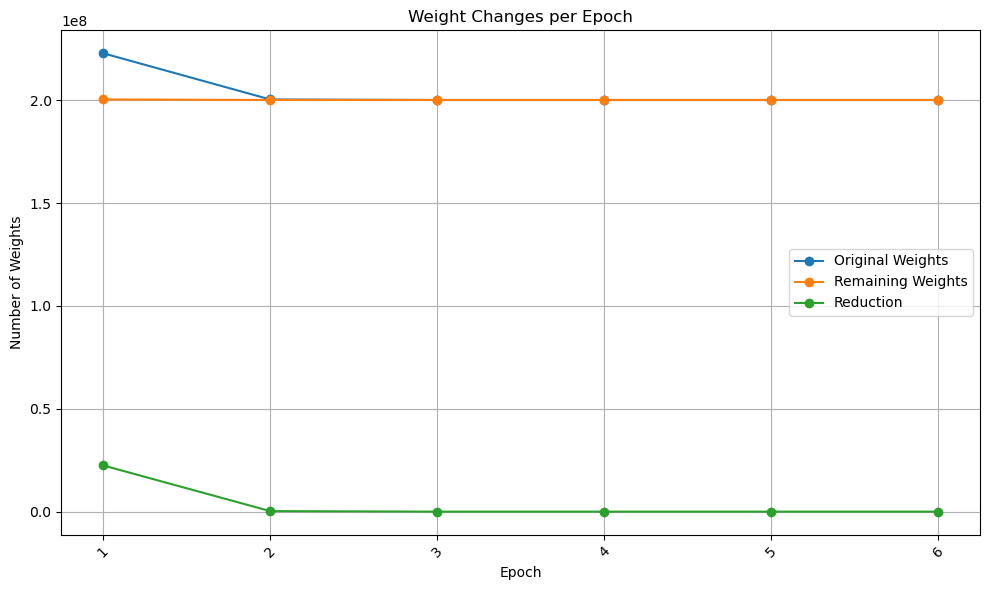

In [18]:
plot_weight_changes(data)

In [19]:
train_file = '../Datasets/Codes/python/train.jsonl'
valid_file = '../Datasets/Codes/python/valid.jsonl'
test_file = '../Datasets/Codes/python/test.jsonl'

In [20]:
import json

def load_code_snippets(file_path):
    code_snippets = []
    tokens = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line.strip())
            code_snippets.append(data['code_tokens'])
            tokens.append(data['docstring_tokens'])
    return code_snippets, tokens

In [21]:
train_snippets, train_tokens = load_code_snippets(train_file)
valid_snippets, valid_tokens = load_code_snippets(valid_file)
test_snippets, test_tokens = load_code_snippets(test_file)

In [22]:
len(train_snippets)

251820

In [23]:
train_snippets[0]

['def',
 'split_phylogeny',
 '(',
 'p',
 ',',
 'level',
 '=',
 '"s"',
 ')',
 ':',
 'level',
 '=',
 'level',
 '+',
 '"__"',
 'result',
 '=',
 'p',
 '.',
 'split',
 '(',
 'level',
 ')',
 'return',
 'result',
 '[',
 '0',
 ']',
 '+',
 'level',
 '+',
 'result',
 '[',
 '1',
 ']',
 '.',
 'split',
 '(',
 '";"',
 ')',
 '[',
 '0',
 ']']

In [24]:
ci = ConcernIdentification(ref_model, model, device='cuda:0', p=0.7)

In [25]:
for idx, (text, tokens) in enumerate(zip(train_snippets, train_tokens)):
    print(idx)
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    print(f"-------------{idx} of the ids-------------")
    random_input_ids = input_ids
    random_decoder_input_ids = generated_ids
    with torch.no_grad():
        y_ = ci.process(text, tokens)
    ci.apply_prune()
    if idx > 5:
        break

0


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
test(model, text)

In [ ]:
test(ref_model, text)